This case study uses four data sources. They are Financial Aid data, Static (demographic) data, and Progress data (which include student's GPA for each term), and finally a training set with studentID and labels of whether the student has dropped out. The goal of this case study is to use logistic regression, svm, and decision tree/ random forest to predict whehter or not a student will drop out and find a model with highest accuracy. In doing so, we can find out the best predicators that can explain student attrition. 

Case Study Structure:
1. Meet the Data   
    a. individual dataset concatenation   
    b. initial feature engineering and feature selection    
    b. merge with training data  
2. EDA   
    a. identify important predicators using correlation matrix       
    b. visualize and drop outliers  
3. Missing Data  
    a. Categorical missing data  
    b. numerical missing data  
    c. missing data in other forms (i.e. -1)  
3. Modeling and Prediction  
    a. Logistic Regression and feature selection   
    b. SVM  
    c. Decision Trees/ Random Forest   
    d. Conclusion  

In [1]:
import numpy as np
import pandas as pd
import csv
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import functools
%matplotlib inline

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

# Training set

In [3]:
trainset=pd.read_csv("DropoutTrainLabels.csv")

In [4]:
trainset.shape

(12261, 2)

In [5]:
trainset.head(10)

,StudentID,Dropout
0,285848,0
1,302176,0
2,301803,0
3,302756,0
4,301067,0
5,297371,1
6,273211,1
7,302772,1
8,280023,0
9,300412,1


In [6]:
trainset.Dropout.value_counts()

0    7527
1    4734
Name: Dropout, dtype: int64

Text(0.5, 0, '1=dropout, 0=non-dropout')

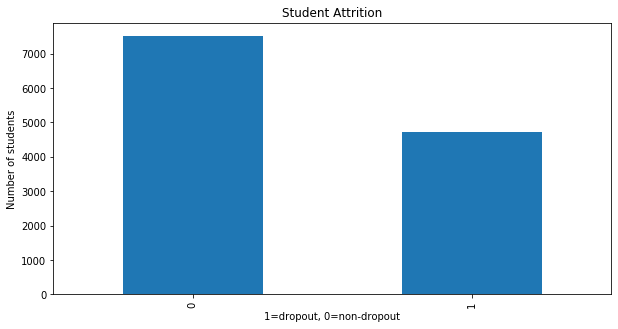

In [7]:
# bar plot of drop out
trainset.Dropout.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Student Attrition")
plt.ylabel('Number of students')
plt.xlabel('1=dropout, 0=non-dropout')

Training set is a bit unbalanced with 0:1 = 7:5 (approximate); we need to resample the training set



# Financial Aid Data

In [8]:
FinancialAid=pd.read_csv("Student Financial Aid Data/2011-2017_Cohorts_Financial_Aid_and_Fafsa_Data.csv")
FinancialAid.head()

,ID with leading,cohort,cohort term,Marital Status,Adjusted Gross Income,Parent Adjusted Gross Income,Father's Highest Grade Level,Mother's Highest Grade Level,Housing,2012 Loan,2012 Scholarship,2012 Work/Study,2012 Grant,2013 Loan,2013 Scholarship,2013 Work/Study,2013 Grant,2014 Loan,2014 Scholarship,2014 Work/Study,2014 Grant,2015 Loan,2015 Scholarship,2015 Work/Study,2015 Grant,2016 Loan,2016 Scholarship,2016 Work/Study,2016 Grant,2017 Loan,2017 Scholarship,2017 Work/Study,2017 Grant
0,297957,2011-12,1,Single,0.0,0.0,College,High School,On Campus Housing,3500.0,NaN,NaN,10714.0,5500.0,NaN,NaN,11095.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,302040,2011-12,1,Single,18096.0,0.0,High School,High School,Off Campus,12500.0,NaN,NaN,3500.0,6250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,234532,2011-12,1,Single,12383.0,0.0,High School,High School,Off Campus,NaN,NaN,NaN,7432.0,5500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,303486,2011-12,1,Married,59303.0,0.0,High School,Middle School,Off Campus,4750.0,NaN,NaN,850.0,2750.0,NaN,NaN,1650.0,10500.0,NaN,NaN,3146.0,5206.0,NaN,NaN,4580.0,NaN,NaN,NaN,691.0,8385.0,NaN,NaN,2233.0
4,304316,2011-12,1,Single,25133.0,0.0,Unknown,High School,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
FinancialAid.tail()

,ID with leading,cohort,cohort term,Marital Status,Adjusted Gross Income,Parent Adjusted Gross Income,Father's Highest Grade Level,Mother's Highest Grade Level,Housing,2012 Loan,2012 Scholarship,2012 Work/Study,2012 Grant,2013 Loan,2013 Scholarship,2013 Work/Study,2013 Grant,2014 Loan,2014 Scholarship,2014 Work/Study,2014 Grant,2015 Loan,2015 Scholarship,2015 Work/Study,2015 Grant,2016 Loan,2016 Scholarship,2016 Work/Study,2016 Grant,2017 Loan,2017 Scholarship,2017 Work/Study,2017 Grant
13764,363982,2016-17,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13765,363983,2016-17,3,Single,5567.0,113774.0,College,College,Off Campus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7500.0,NaN,NaN,NaN
13766,364047,2016-17,3,Separated,12578.0,0.0,High School,High School,Off Campus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5500.0,NaN,NaN,7966.0
13767,364159,2016-17,3,NaN,NaN,NaN,NaN,NaN,Off Campus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN
13768,364184,2016-17,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On difference between scholarship and grant in general, see [this article](https://www.savingforcollege.com/article/what-is-the-difference-between-grants-and-scholarships#:~:text=Grants%20and%20scholarships%20are%20both,student%20employment%20and%20student%20loans.&text=Grants%20tend%20to%20be%20based,to%20be%20based%20on%20merit.).


In [10]:
#check data type
FinancialAid.dtypes

ID with leading                   int64
cohort                           object
cohort term                       int64
Marital Status                   object
Adjusted Gross Income           float64
Parent Adjusted Gross Income    float64
Father's Highest Grade Level     object
Mother's Highest Grade Level     object
Housing                          object
2012 Loan                       float64
2012 Scholarship                float64
2012 Work/Study                 float64
2012 Grant                      float64
2013 Loan                       float64
2013 Scholarship                float64
2013 Work/Study                 float64
2013 Grant                      float64
2014 Loan                       float64
2014 Scholarship                float64
2014 Work/Study                 float64
2014 Grant                      float64
2015 Loan                       float64
2015 Scholarship                float64
2015 Work/Study                 float64
2015 Grant                      float64


In [11]:
#check the unique values for object data type variables: 
#Marital Status, Father's Highest Grade Level, Mother's highest Grade Level, Housing
print("Marital Status :" + str(FinancialAid['Marital Status'].unique()))
print("Father's Highest Grade Level :" + str(FinancialAid["Father's Highest Grade Level"].unique()))
print("Mother's Highest Grade Level :" + str(FinancialAid["Mother's Highest Grade Level"].unique()))
print("Housing :" + str(FinancialAid["Housing"].unique()))

Marital Status :['Single' 'Married' 'Separated' nan 'Divorced']
Father's Highest Grade Level :['College' 'High School' 'Unknown' 'Middle School' nan]
Mother's Highest Grade Level :['High School' 'Middle School' 'College' nan 'Unknown']
Housing :['On Campus Housing' 'Off Campus' nan 'With Parent']


In [12]:
# create a copy;
FinAid=FinancialAid.copy()

In [13]:
# rename a few columns for easier retrieval
FinAid=FinAid.rename(columns={"ID with leading": "StudentID",
                             "Marital Status":"Marital_Status",
                             "Adjusted Gross Income": "AGI",
                             "Parent Adjusted Gross Income":"Parent_AGI",
                             "Father's Highest Grade Level":"Father_Ed",
                             "Mother's Highest Grade Level":"Mother_Ed"})
FinAid.sample()

,StudentID,cohort,cohort term,Marital_Status,AGI,Parent_AGI,Father_Ed,Mother_Ed,Housing,2012 Loan,2012 Scholarship,2012 Work/Study,2012 Grant,2013 Loan,2013 Scholarship,2013 Work/Study,2013 Grant,2014 Loan,2014 Scholarship,2014 Work/Study,2014 Grant,2015 Loan,2015 Scholarship,2015 Work/Study,2015 Grant,2016 Loan,2016 Scholarship,2016 Work/Study,2016 Grant,2017 Loan,2017 Scholarship,2017 Work/Study,2017 Grant
6185,23538,2013-14,3,Single,28376.0,0.0,College,High School,Off Campus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#check and drop duplicate rows
FinAid.shape

(13769, 33)

In [15]:
FinAid_dups=FinAid[FinAid.duplicated()]
print("number of duplicate rows in Financial Aid data is {}".format(len(FinAid_dups)))

number of duplicate rows in Financial Aid data is 0


In [16]:
#FinAid.count()

In [17]:
#check number of missing values in each column
print(FinAid.isnull().sum())

StudentID               0
cohort                  0
cohort term             0
Marital_Status       2154
AGI                  2154
Parent_AGI           2154
Father_Ed            2292
Mother_Ed            2520
Housing              2164
2012 Loan           12532
2012 Scholarship    13598
2012 Work/Study     13666
2012 Grant          12415
2013 Loan           11582
2013 Scholarship    13459
2013 Work/Study     13590
2013 Grant          11450
2014 Loan           11028
2014 Scholarship    13353
2014 Work/Study     13526
2014 Grant          10840
2015 Loan           10718
2015 Scholarship    13174
2015 Work/Study     13520
2015 Grant          10365
2016 Loan           10594
2016 Scholarship    13084
2016 Work/Study     13497
2016 Grant          10075
2017 Loan           10445
2017 Scholarship    12784
2017 Work/Study     13402
2017 Grant           9732
dtype: int64


The 2012-2017 loan, scholarship, work/study, grant columns have many missing values; to make these columns more useful, I will create a few features based on these columns.

In [18]:
#try add features: Avg_loan; Avg_Scholarship, Avg_Grant, Avg_workstudy
#or should I drop the columns because they contain too many missing values??



In [19]:
# detecting outliers 
#(but why should we remove outliers? need to use statistical threshold to decide whether the outliers are influential enough that we need to get rid of them)


In [20]:
# check marital_status missing values
FinAid['Marital_Status'].isnull().sum()

2154

`Marital_Status` has about 15.6% missing values.

In [21]:
# for categorical variables
FinAid['Marital_Status'].value_counts()
#pd.count_values()

Single       10155
Married       1024
Divorced       236
Separated      200
Name: Marital_Status, dtype: int64

Text(0.5, 0, 'Marital Status')

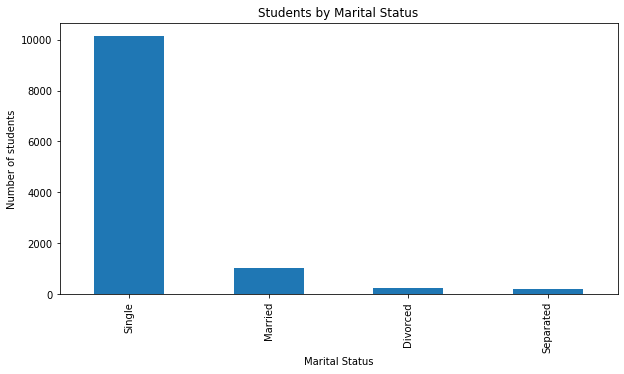

In [22]:
FinAid.Marital_Status.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Students by Marital Status")
plt.ylabel('Number of students')
plt.xlabel('Marital Status')

In [23]:
FinAid['Father_Ed'].value_counts()

High School      5092
College          3284
Unknown          1771
Middle School    1330
Name: Father_Ed, dtype: int64

In [24]:
FinAid['Father_Ed'].value_counts(normalize=True)

High School      0.443670
College          0.286137
Unknown          0.154309
Middle School    0.115884
Name: Father_Ed, dtype: float64

"Unknown" is a separate value entry which is different from nan (missing values). So that the total % of missing values for `Father_Ed` is (1771 + 2292)/13769=29.5%

Text(0.5, 0, 'Father Education Level')

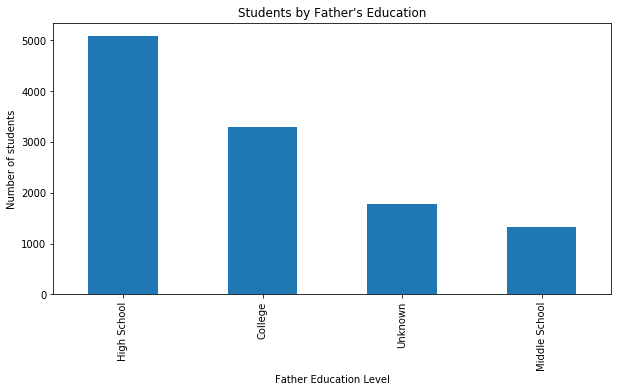

In [25]:
FinAid.Father_Ed.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Students by Father's Education")
plt.ylabel('Number of students')
plt.xlabel('Father Education Level')

In [26]:
FinAid['Mother_Ed'].value_counts()

High School      5024
College          3215
Unknown          1714
Middle School    1296
Name: Mother_Ed, dtype: int64

In [27]:
FinAid['Mother_Ed'].value_counts(normalize=True)

High School      0.446617
College          0.285803
Unknown          0.152369
Middle School    0.115210
Name: Mother_Ed, dtype: float64

Similar to `Father_Ed`, "unknown" values does not include missing values. So the true missing value rate is (1714+2520)/13769=30.8%

Text(0.5, 0, 'Mother Education Level')

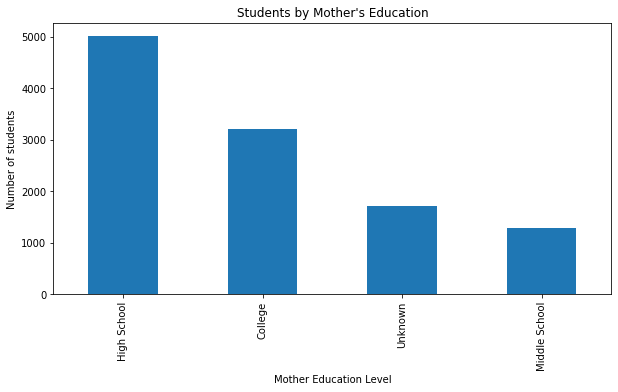

In [28]:
FinAid.Mother_Ed.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Students by Mother's Education")
plt.ylabel('Number of students')
plt.xlabel('Mother Education Level')

In [29]:
FinAid['Housing'].value_counts()

Off Campus           5373
With Parent          4608
On Campus Housing    1624
Name: Housing, dtype: int64

In [30]:
print("Missing value rate for variable housing is: {}".format((FinAid['Housing'].isnull().sum())/len(FinAid)))

Missing value rate for variable housing is: 0.1571646452175176


Text(0.5, 0, 'Housing')

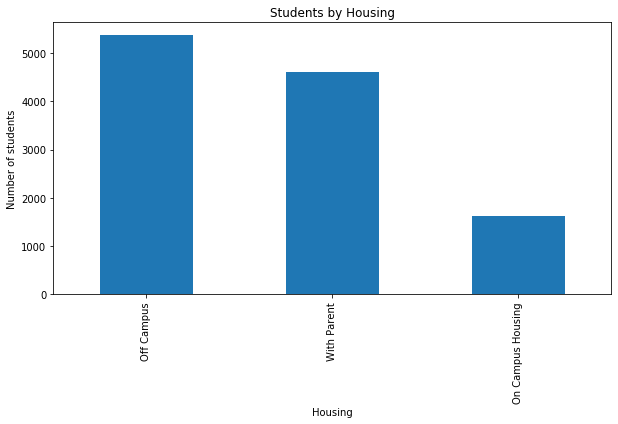

In [31]:
FinAid.Housing.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Students by Housing")
plt.ylabel('Number of students')
plt.xlabel('Housing')

In [32]:
len(FinancialAid)

13769

# static data

In [33]:
# I'm not sure whether the csv files for static data are cumulative or only includes the static data for student for that term

StaticFall11=pd.read_csv("Student Static Data/Fall 2011_ST.csv")
StaticSpring12=pd.read_csv("Student Static Data/Spring 2012_ST.csv")
StaticFall12=pd.read_csv("Student Static Data/Fall 2012.csv")
StaticFall13=pd.read_csv("Student Static Data/Fall 2013.csv")

In [34]:
StaticFall11.shape

(1759, 35)

In [35]:
StaticSpring12.shape

(543, 35)

In [36]:
StaticFall12.shape

(1779, 35)

In [37]:
StaticFall13.shape

(1615, 35)

In [38]:
StaticFall11.head()

,StudentID,Cohort,CohortTerm,Campus,Address1,Address2,City,State,Zip,RegistrationDate,Gender,BirthYear,BirthMonth,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,TwoOrMoreRace,HSDip,HSDipYr,HSGPAUnwtd,HSGPAWtd,FirstGen,DualHSSummerEnroll,EnrollmentStatus,NumColCredAttemptTransfer,NumColCredAcceptTransfer,CumLoanAtEntry,HighDeg,MathPlacement,EngPlacement,GatewayMathStatus,GatewayEnglishStatus
0,285848,2011-12,1,NaN,328 Adams St Apt 1,NaN,Hoboken,NJ,7030.0,20110808,2,1978.0,9,0,0,0,0,0,1,0,1,-1,-1.00,-1,-1,0,2,0.0,0.0,-1,0,0,0,0,0
1,302176,2011-12,1,NaN,142 Cherry St,NaN,Jersey City,NJ,7305.0,20110804,1,1970.0,4,0,0,0,0,0,1,0,1,-1,-1.00,-1,-1,0,2,96.0,45.0,-1,0,0,0,0,0
2,301803,2011-12,1,NaN,12 Rainbow Street,NaN,Presque Isle,ME,4769.0,20110809,2,1984.0,4,0,0,0,0,0,1,0,1,-1,-1.00,-1,-1,0,2,0.0,0.0,-1,0,0,0,0,0
3,302756,2011-12,1,NaN,345 4th St Apt 2,NaN,Jersey City,NJ,7302.0,20110823,2,1986.0,1,0,0,0,0,0,1,0,-1,-1,-1.00,-1,-1,0,2,54.0,87.5,-1,0,0,0,0,0
4,300304,2011-12,1,NaN,6600 Broadway,Apt 3D,West New York,NJ,7093.0,20110725,1,1992.0,2,1,0,0,0,0,0,0,1,2010,3.13,-1,-1,0,1,-2.0,-2.0,-2,0,1,0,0,0


In [39]:
Fall11ID=[ind_ID for ind_ID in StaticFall11["StudentID"]]
type(Fall11ID)

list

In [40]:
Fall11ID[0]

285848

In [41]:
Fall12ID=[ind_ID for ind_ID in StaticFall12["StudentID"]]
for each_ID in Fall11ID:
    if each_ID in Fall12ID:
        print("fall 12's data contains previous student records")
print("fall 12's data does not contain previous student records")

fall 12's data does not contain previous student records


In [42]:
# so we should be able to concatenate all the static student data into one file for all students' static data
STFileNames=glob.glob("Student Static Data/*.csv")
AllST=[]
for file in STFileNames:
    AllST.append(pd.read_csv(file))
AllSTDF=pd.concat(AllST, ignore_index=True)    


In [43]:
AllSTDF.shape

(13261, 35)

In [44]:
AllSTDF.head(10)

,StudentID,Cohort,CohortTerm,Campus,Address1,Address2,City,State,Zip,RegistrationDate,Gender,BirthYear,BirthMonth,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,TwoOrMoreRace,HSDip,HSDipYr,HSGPAUnwtd,HSGPAWtd,FirstGen,DualHSSummerEnroll,EnrollmentStatus,NumColCredAttemptTransfer,NumColCredAcceptTransfer,CumLoanAtEntry,HighDeg,MathPlacement,EngPlacement,GatewayMathStatus,GatewayEnglishStatus
0,27936,2015-16,3,NaN,61 Neptune Ave,NaN,Jersey City,NJ,7305.0,20150116,2,1969.0,10,1,0,0,0,0,0,0,1,-1,-1.0,-1,-1,0,2,102.0,66.0,-1,2,0,0,0,0
1,44318,2015-16,3,NaN,400 Armstrong Ave,NaN,Jersey City,NJ,7305.0,20150122,2,1993.0,11,0,1,0,0,0,0,0,1,-1,-1.0,-1,-1,0,2,79.0,66.0,-1,2,0,0,0,0
2,67421,2015-16,3,NaN,96 Ocean Avenue,Apt. 2,Jersey City,NJ,7305.0,20160106,2,1966.0,5,1,0,0,0,0,0,0,1,-1,-1.0,-1,-1,0,2,91.0,66.0,-1,2,0,0,0,0
3,70833,2015-16,3,NaN,79 Pearsall Ave,NaN,Jersey City,NJ,7305.0,20150119,2,1983.0,2,1,0,0,0,0,0,0,1,-1,-1.0,-1,-1,0,2,0.0,0.0,-1,2,0,0,0,0
4,90356,2015-16,3,NaN,192 Olean Ave,NaN,Jersey City,NJ,7306.0,20160105,2,1985.0,9,0,0,0,1,0,0,0,1,-1,-1.0,-1,-1,0,2,67.0,64.0,-1,0,0,0,1,0
5,90509,2015-16,3,NaN,102 Bartholdi Ave,NaN,Jersey City,NJ,7305.0,20160107,1,1992.0,10,0,0,0,1,0,0,0,1,-1,-1.0,-1,-1,0,2,63.0,63.0,-1,2,0,0,0,0
6,102573,2015-16,3,NaN,5 Denise Ct,NaN,Tinton Falls,NJ,7753.0,20151215,2,1974.0,11,0,0,0,0,0,1,0,1,-1,-1.0,-1,-1,0,2,150.0,86.0,-1,2,0,0,0,0
7,107508,2015-16,3,NaN,275 William St,NaN,Belleville,NJ,7109.0,20150123,2,1975.0,8,1,0,0,0,0,0,0,1,-1,-1.0,-1,-1,0,2,75.0,57.0,-1,2,0,0,0,0
8,201520,2015-16,3,NaN,51A Winfield Avenue,NaN,Jersey City,NJ,7305.0,20160119,2,1986.0,2,0,0,0,0,0,1,0,1,-1,-1.0,-1,-1,0,2,-1.0,66.0,-1,0,0,0,0,0
9,203416,2015-16,3,NaN,16 Bayside Pl,NaN,Jersey City,NJ,7305.0,20160104,2,1986.0,9,0,0,0,1,0,0,0,1,-1,-1.0,-1,-1,0,2,128.0,59.0,-1,0,0,0,0,0


In [45]:
# check for duplicates
Static_dups=AllSTDF[AllSTDF.duplicated()]
print("number of duplicate rows in Static data is {}".format(len(Static_dups)))

number of duplicate rows in Static data is 0


In [46]:
AllSTDF.dtypes

StudentID                      int64
Cohort                        object
CohortTerm                     int64
Campus                       float64
Address1                      object
Address2                      object
City                          object
State                         object
Zip                          float64
RegistrationDate               int64
Gender                         int64
BirthYear                    float64
BirthMonth                     int64
Hispanic                       int64
AmericanIndian                 int64
Asian                          int64
Black                          int64
NativeHawaiian                 int64
White                          int64
TwoOrMoreRace                  int64
HSDip                          int64
HSDipYr                        int64
HSGPAUnwtd                   float64
HSGPAWtd                       int64
FirstGen                       int64
DualHSSummerEnroll             int64
EnrollmentStatus               int64
N

In [47]:
#look at unique values for cohort
AllSTDF['Cohort'].unique()

array(['2015-16', '2014-15', '2013-14', '2012-13', '2016-17', '2011-12'],
      dtype=object)

In [48]:
AllSTDF['CohortTerm'].unique()

array([3, 1])

In [49]:
# check each column's missing values
AllSTDF.isnull().sum()

StudentID                        0
Cohort                           0
CohortTerm                       0
Campus                       13261
Address1                       113
Address2                     12872
City                           114
State                          113
Zip                            134
RegistrationDate                 0
Gender                           0
BirthYear                        1
BirthMonth                       0
Hispanic                         0
AmericanIndian                   0
Asian                            0
Black                            0
NativeHawaiian                   0
White                            0
TwoOrMoreRace                    0
HSDip                            0
HSDipYr                          0
HSGPAUnwtd                       0
HSGPAWtd                         0
FirstGen                         0
DualHSSummerEnroll               0
EnrollmentStatus                 0
NumColCredAttemptTransfer        0
NumColCredAcceptTran

From looking at the number of missing values, we see that we can safely drop the campus column as it contains no missing value. I will also drop address1, address 2 because they contain many missing values and for geo-location, I will keep state as a predicator variable on the general level, but I will keep city and zip for now (maybe they will become useful for imputing missing values for state).

But it's important to note that according to the data dictionary, missing values are recorded as -1; so although we didn't see nan in some of the columns, there still might be missing values in the columns. So it is worth looking at each distribution of the variables to determine how many missing values they contain.

In [50]:
# make a copy of the dataframe and start dropping a few columns
Static=AllSTDF.copy()
Static=Static.drop(['Campus','Address2'], axis=1)
Static.shape

(13261, 33)

In [51]:
# Gender
Static['Gender'].unique() #

array([2, 1])

In [52]:
Static.Gender.value_counts()

2    7899
1    5362
Name: Gender, dtype: int64

In [53]:
if -1 in Static['Gender']:
    print("gender consists of missing value")

In [54]:
# HSDip distribution 
Static.HSDip.value_counts()

 1    12887
-1      289
 2       75
 4       10
Name: HSDip, dtype: int64

In [55]:
#frequency distribution
Static.HSDip.value_counts(normalize=True)

 1    0.971797
-1    0.021793
 2    0.005656
 4    0.000754
Name: HSDip, dtype: float64

For students' high school completion status, the majority had a high school diploma (1), 289 records are missing, and 75 students received GED certificate and 10 received other forms of high school certificates.

In [56]:
# HSDipYr
Static.HSDipYr.value_counts(normalize=True)

-1       0.722495
 2016    0.048563
 2015    0.044416
 2012    0.039967
 2014    0.039439
 2011    0.038685
 2013    0.032200
 2010    0.016816
 2009    0.003770
 2007    0.001885
 2008    0.001810
 2005    0.001734
 2002    0.001131
 2006    0.000980
 2001    0.000830
 2004    0.000830
 1994    0.000603
 2000    0.000528
 1998    0.000452
 2003    0.000377
 1997    0.000302
 1983    0.000226
 1996    0.000226
 1993    0.000226
 1990    0.000151
 1987    0.000151
 1970    0.000151
 1978    0.000151
 1991    0.000151
 1980    0.000075
 1963    0.000075
 1971    0.000075
 1979    0.000075
 1995    0.000075
 1988    0.000075
 1989    0.000075
 1982    0.000075
 1999    0.000075
 1984    0.000075
Name: HSDipYr, dtype: float64

Interesting as it is, this variable `HSDipYr` has many missing values and might not be as useful.

In [57]:
# HSGPAUnwtd
Static.HSGPAUnwtd.value_counts(normalize=True)

-1.00    0.702662
 2.70    0.016062
 2.80    0.015006
 2.50    0.014479
 3.00    0.012518
           ...   
 1.53    0.000075
 2.05    0.000075
 1.95    0.000075
 1.89    0.000075
 3.86    0.000075
Name: HSGPAUnwtd, Length: 214, dtype: float64

In [58]:
len(Static[Static['HSGPAUnwtd']==-1])

9318

In [59]:
HSGPAUnwtd=Static[Static['HSGPAUnwtd']!=-1]

Again, about 70% of the values in high school unweighted GPA are missing; likely not going to be useful.

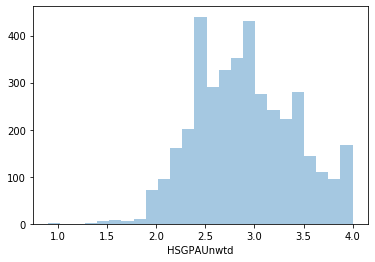

In [60]:
# plot the non-missing HSGPAUnwtd
sns.distplot(HSGPAUnwtd['HSGPAUnwtd'], hist=True, kde=False, bins=25)

In [61]:
# HSGPAWtd
Static.HSGPAWtd.value_counts()

-1    13261
Name: HSGPAWtd, dtype: int64

So we've discovered another variable `HSGPAWtd` that needs to be dropped because it contains no useful info, together with `HSGPAUnwtd`, and `HSDipYr`.

In [62]:
# FirstGen
Static.FirstGen.value_counts(normalize=True)

-1    1.0
Name: FirstGen, dtype: float64

Adding on to the drop list, `FirstGen` also contains no useful info.

In [63]:
#DualHSSummerEnroll
Static.DualHSSummerEnroll.value_counts()

0    13261
Name: DualHSSummerEnroll, dtype: int64

This indicates that all the students do not have past dual enroolment nor summer enrollment (DualHSSummerEnroll=0). Again, `DualHSSummerEnroll` adds no useful information and needs to be dropped.

In [64]:
# EnrollmentStatus
Static.EnrollmentStatus.value_counts(normalize=True)

2    0.58887
1    0.41113
Name: EnrollmentStatus, dtype: float64

In [65]:
Static.EnrollmentStatus.isnull().sum()

0

The above sum shows that `EnrollmentStatus` does not have missing values. And out of the 13261 students, about 58.9% entered as transfer students (`EnrollmentStatus`=2) and 41.1% enetered as freshman (`EnrollmentStatus`=1). We can engineer a new feature to indicate freshman (`Freshman`=1, `Transfer`=0).

In [66]:
#NumColCredAcceptTransfer
Static.NumColCredAcceptTransfer.value_counts()

-2.0     5452
 66.0    1560
 0.0      682
 96.0     487
 65.0     391
         ... 
 72.5       1
 1.0        1
 29.5       1
 50.5       1
 15.5       1
Name: NumColCredAcceptTransfer, Length: 178, dtype: int64

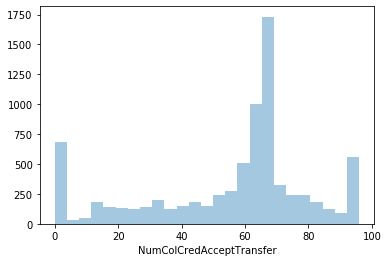

In [67]:
# visualize the distribution of NumColCredAcceptTransfer for transfer students
sns.distplot(Static['NumColCredAcceptTransfer'][(Static['NumColCredAcceptTransfer']!=-2) & (Static['NumColCredAcceptTransfer']!=-1)], 
             hist=True, kde=False, bins=25)


In [68]:
#CumLoanAtEntry
Static.CumLoanAtEntry.value_counts()

-1    7809
-2    5452
Name: CumLoanAtEntry, dtype: int64

In [69]:
Static.CumLoanAtEntry.isnull().sum()

0

The above result shows that all the transfer students's data are missing (`CumLoanAtEntry`=-1); and the rest do not apply (`CumLoanAtEntry`=-2). This variable also didn't provide useful info.

In [70]:
#HighDeg
Static.HighDeg.value_counts()

0    9463
2    3639
3     157
4       2
Name: HighDeg, dtype: int64

Of all the students, 9463 don't have a postsecondary degree; 3639 have associate degree; 157 have bachelor's degree, and  2 have degrees higher than bachelor's.

In [71]:
# MathPlacement
Static.MathPlacement.value_counts()

 0    8415
 1    4275
-1     571
Name: MathPlacement, dtype: int64

In [72]:
Static.MathPlacement.isnull().sum()

0

`MathPlacement`=0 indicates college readiness for math; `MathPlacement`=1 indicates not ready for college math. Missing value % is 4.3%

In [73]:
# EngPlacement
Static.EngPlacement.value_counts()

 0    9640
 1    3050
-1     571
Name: EngPlacement, dtype: int64

In [74]:
Static.EngPlacement.isnull().sum()

0

`EngPlacement`=0 indicates college readiness for English; `MathPlacement`=1 indicates not ready for college English. Missing value % is 4.3%

In [75]:
# GatewayMathStatus
Static.GatewayMathStatus.value_counts()

0    11673
1     1588
Name: GatewayMathStatus, dtype: int64

`GatewayMathStatus`=0 indicates Gateway math course is not required for student at the time of entry; `GatewayMathStatus`=1 indicates Gateway math course is required for student at the time of entry.

In [76]:
# GatewayEnglishStatus
Static.GatewayEnglishStatus.value_counts()

0    10739
1     2522
Name: GatewayEnglishStatus, dtype: int64

`GatewayEnglishStatus`=0 indicates Gateway English course is not required for student at the time of entry; `GatewayEnglishStatus`=1 indicates Gateway English course is required for student at the time of entry.

In [77]:
# drop the columns 
Static=Static.drop(['HSGPAWtd','HSGPAUnwtd','HSDipYr','FirstGen','DualHSSummerEnroll','CumLoanAtEntry'], axis=1)
Static.shape

(13261, 27)

In [78]:
Static.columns

Index(['StudentID', 'Cohort', 'CohortTerm', 'Address1', 'City', 'State', 'Zip',
       'RegistrationDate', 'Gender', 'BirthYear', 'BirthMonth', 'Hispanic',
       'AmericanIndian', 'Asian', 'Black', 'NativeHawaiian', 'White',
       'TwoOrMoreRace', 'HSDip', 'EnrollmentStatus',
       'NumColCredAttemptTransfer', 'NumColCredAcceptTransfer', 'HighDeg',
       'MathPlacement', 'EngPlacement', 'GatewayMathStatus',
       'GatewayEnglishStatus'],
      dtype='object')

## Feature 1. EntryAge

EntryAge= RegistrationYear - BirthYear

In [79]:
print(int(str(Static.loc[0,'RegistrationDate'])[:4]))

2015


In [80]:
# generate new column registration year
Static['RegistrationYear']=Static['RegistrationDate'].apply(lambda x:int(str(x)[:4]))
Static.sample()

,StudentID,Cohort,CohortTerm,Address1,City,State,Zip,RegistrationDate,Gender,BirthYear,BirthMonth,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,TwoOrMoreRace,HSDip,EnrollmentStatus,NumColCredAttemptTransfer,NumColCredAcceptTransfer,HighDeg,MathPlacement,EngPlacement,GatewayMathStatus,GatewayEnglishStatus,RegistrationYear
9798,354839,2016-17,1,939 Virginia Ct,Atlantic City,NJ,8401.0,20160622,2,1998.0,4,0,0,0,1,0,0,0,1,1,-2.0,-2.0,0,1,0,0,1,2016


In [81]:
#check datatype 
Static.RegistrationYear.dtypes

dtype('int64')

In [82]:
# check missing values
Static.RegistrationYear.isnull().sum()

0

In [83]:
# generate new column EntryAge
Static['EntryAge']=Static['RegistrationYear']-Static['BirthYear']
Static.sample()

,StudentID,Cohort,CohortTerm,Address1,City,State,Zip,RegistrationDate,Gender,BirthYear,BirthMonth,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,TwoOrMoreRace,HSDip,EnrollmentStatus,NumColCredAttemptTransfer,NumColCredAcceptTransfer,HighDeg,MathPlacement,EngPlacement,GatewayMathStatus,GatewayEnglishStatus,RegistrationYear,EntryAge
6332,329695,2014-15,1,1602 75th St,North Bergen,NJ,7047.0,20140423,2,1993.0,8,0,0,0,0,0,1,0,1,2,88.0,69.0,0,0,0,0,0,2014,21.0


In [84]:
# check datatype and missing values 
Static.EntryAge.dtypes

dtype('float64')

In [85]:
#there should be one missing value since birthyear contains one missing value
Static.EntryAge.isnull().sum()

1

In [86]:
# also drop birthmonth since it is a bit irrelevant
Static=Static.drop(['BirthMonth'], axis=1)
Static.shape

(13261, 28)

Text(0.5, 0, 'Age')

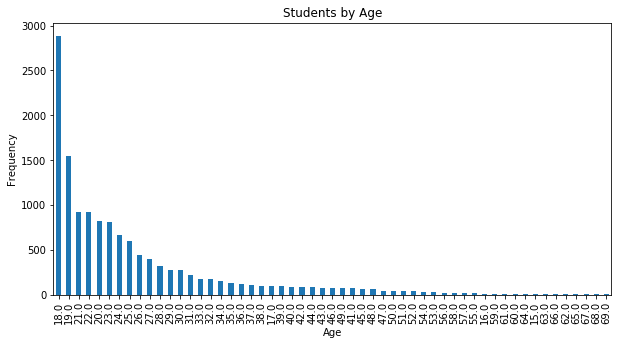

In [87]:
# distribution of age
Static.EntryAge.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Students by Age")
plt.ylabel('Frequency')
plt.xlabel('Age')

The majority of students are around 18-25 years old. 

## Feature 2. Gender

In [88]:
Static.Gender.value_counts()

2    7899
1    5362
Name: Gender, dtype: int64

In the original dataframe, `Gender` is coded as an ordinal variable where 1= Male and 2=Female. Since this order is not inherent, it doesn't make sense to code gender as an ordinal variable. As such, I will re-engineer `Gender` as an indicator variable where 1=Male, and 0=Female.

In [89]:
Static=Static.replace({'Gender':{2:0}})
Static.Gender.value_counts()

0    7899
1    5362
Name: Gender, dtype: int64

In [90]:
Static.sample(2)

,StudentID,Cohort,CohortTerm,Address1,City,State,Zip,RegistrationDate,Gender,BirthYear,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,TwoOrMoreRace,HSDip,EnrollmentStatus,NumColCredAttemptTransfer,NumColCredAcceptTransfer,HighDeg,MathPlacement,EngPlacement,GatewayMathStatus,GatewayEnglishStatus,RegistrationYear,EntryAge
1206,314501,2013-14,3,67 S Munn Ave Apt 1C,East Orange,NJ,7018.0,20131213,0,1960.0,-1,-1,-1,-1,-1,-1,-1,1,2,90.0,66.0,2,0,0,0,0,2013,53.0
516,137622,2014-15,3,140 Johnson Ln,Parlin,NJ,7002.0,20150120,0,1968.0,0,0,0,0,0,1,0,1,2,81.5,55.5,0,0,0,0,0,2015,47.0


## Feature 2. Minority

There are currently 7 race categories in the predicator variables. They are `Hispanic`, `AmericanIndian`, `Asian`, `Black`, `NativeHawaiian`, `White`, and `TwoOrMoreRace`. Let's look at each.

In all these race categories, 0 indicates No; 1 indicates Yes; -1 indicates missing.

In [91]:
Static.Hispanic.value_counts()

 0    8020
 1    4323
-1     918
Name: Hispanic, dtype: int64

In [92]:
Static.AmericanIndian.value_counts()

 0    12319
-1      918
 1       24
Name: AmericanIndian, dtype: int64

In [93]:
Static.Asian.value_counts()

 0    11180
 1     1163
-1      918
Name: Asian, dtype: int64

In [94]:
Static.Black.value_counts()

 0    9506
 1    2837
-1     918
Name: Black, dtype: int64

In [95]:
Static.NativeHawaiian.value_counts()

 0    12321
-1      918
 1       22
Name: NativeHawaiian, dtype: int64

In [96]:
Static.White.value_counts()

 0    8998
 1    3345
-1     918
Name: White, dtype: int64

In [97]:
Static.TwoOrMoreRace.value_counts()

 0    12112
-1      918
 1      231
Name: TwoOrMoreRace, dtype: int64

 231 out of all students belong to more than one racial category.

In [98]:
# if student belong to any minority racial group, indicate that student as 1.
Static['Minority']= np.where(((Static['Hispanic']==1)|(Static['AmericanIndian']==1)|(Static['Asian']==1)
                            |(Static['Black']==1) | (Static['NativeHawaiian']==1)), 1, 
                             (np.where(((Static['Hispanic']==-1)&(Static['AmericanIndian']==-1)&(Static['Asian']==-1)
                            &(Static['Black']==-1) & (Static['NativeHawaiian']==-1)),-1,0)))


In [99]:
Static.head(5)

,StudentID,Cohort,CohortTerm,Address1,City,State,Zip,RegistrationDate,Gender,BirthYear,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,TwoOrMoreRace,HSDip,EnrollmentStatus,NumColCredAttemptTransfer,NumColCredAcceptTransfer,HighDeg,MathPlacement,EngPlacement,GatewayMathStatus,GatewayEnglishStatus,RegistrationYear,EntryAge,Minority
0,27936,2015-16,3,61 Neptune Ave,Jersey City,NJ,7305.0,20150116,0,1969.0,1,0,0,0,0,0,0,1,2,102.0,66.0,2,0,0,0,0,2015,46.0,1
1,44318,2015-16,3,400 Armstrong Ave,Jersey City,NJ,7305.0,20150122,0,1993.0,0,1,0,0,0,0,0,1,2,79.0,66.0,2,0,0,0,0,2015,22.0,1
2,67421,2015-16,3,96 Ocean Avenue,Jersey City,NJ,7305.0,20160106,0,1966.0,1,0,0,0,0,0,0,1,2,91.0,66.0,2,0,0,0,0,2016,50.0,1
3,70833,2015-16,3,79 Pearsall Ave,Jersey City,NJ,7305.0,20150119,0,1983.0,1,0,0,0,0,0,0,1,2,0.0,0.0,2,0,0,0,0,2015,32.0,1
4,90356,2015-16,3,192 Olean Ave,Jersey City,NJ,7306.0,20160105,0,1985.0,0,0,0,1,0,0,0,1,2,67.0,64.0,0,0,0,1,0,2016,31.0,1


In [100]:
# check
Static.Minority.value_counts()

 1    8369
 0    3974
-1     918
Name: Minority, dtype: int64

In [101]:
Static.Minority.value_counts(normalize=True)

 1    0.631099
 0    0.299676
-1    0.069226
Name: Minority, dtype: float64

## Feature 3. Transfer vs. Freshman

In [102]:
Static.EnrollmentStatus.value_counts()

2    7809
1    5452
Name: EnrollmentStatus, dtype: int64

For the variable `EnrollmentStatus`, 2 indicates entering as transfer student; 1 indicates entering as freshman. Since there are no internal order between the two types of students, it does not make sense to use an ordinal variable. I will create an indicator variable `Freshman` where 1 indicates Freshman and 0 indicaets transfer students.

In [103]:
Static=Static.replace({'EnrollmentStatus': {2:0}})
Static=Static.rename(columns={'EnrollmentStatus': 'Freshman'})
Static.sample()

,StudentID,Cohort,CohortTerm,Address1,City,State,Zip,RegistrationDate,Gender,BirthYear,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,TwoOrMoreRace,HSDip,Freshman,NumColCredAttemptTransfer,NumColCredAcceptTransfer,HighDeg,MathPlacement,EngPlacement,GatewayMathStatus,GatewayEnglishStatus,RegistrationYear,EntryAge,Minority
9664,292253,2016-17,1,73 Danforth Ave,Jersey City,NJ,7305.0,20160825,1,1992.0,1,0,0,0,0,0,0,1,0,39.0,35.0,0,0,0,0,0,2016,24.0,1


In [104]:
Static.columns

Index(['StudentID', 'Cohort', 'CohortTerm', 'Address1', 'City', 'State', 'Zip',
       'RegistrationDate', 'Gender', 'BirthYear', 'Hispanic', 'AmericanIndian',
       'Asian', 'Black', 'NativeHawaiian', 'White', 'TwoOrMoreRace', 'HSDip',
       'Freshman', 'NumColCredAttemptTransfer', 'NumColCredAcceptTransfer',
       'HighDeg', 'MathPlacement', 'EngPlacement', 'GatewayMathStatus',
       'GatewayEnglishStatus', 'RegistrationYear', 'EntryAge', 'Minority'],
      dtype='object')

## Feature 4. Highest Degree (None), Associate Degree, Bachelor's Degree, Higher than Bachelor's

In [105]:
Static.HighDeg.value_counts()

0    9463
2    3639
3     157
4       2
Name: HighDeg, dtype: int64

Of all the students, 9463 don't have a postsecondary degree; 3639 have associate degree; 157 have bachelor's degree, and  2 have degrees higher than bachelor's.

Instead of treating `HighDeg` as an ordinal variable as the original data, I will create a dummy variablesfor HighDeg where H_1=None postsecondary degree; H_2=Associate degree; H_3=Bachelor and higher

First, since there are only two records for `HighDeg`=4, I will combine 3 and 4 into 3 so that there will be downsized to three levels for `HighDeg`.

In [106]:
Static=Static.replace({"HighDeg":{4:3}})
Static.HighDeg.value_counts()

0    9463
2    3639
3     159
Name: HighDeg, dtype: int64

In [107]:
Static=pd.get_dummies(Static, columns=['HighDeg'])
Static.sample()

,StudentID,Cohort,CohortTerm,Address1,City,State,Zip,RegistrationDate,Gender,BirthYear,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,TwoOrMoreRace,HSDip,Freshman,NumColCredAttemptTransfer,NumColCredAcceptTransfer,MathPlacement,EngPlacement,GatewayMathStatus,GatewayEnglishStatus,RegistrationYear,EntryAge,Minority,HighDeg_0,HighDeg_2,HighDeg_3
4183,321373,2013-14,1,150 George Russell Way,Clifton,NJ,7013.0,20130725,0,1969.0,0,0,1,0,0,0,0,1,0,0.0,0.0,0,0,0,0,2013,44.0,1,1,0,0


In [108]:
Static.columns

Index(['StudentID', 'Cohort', 'CohortTerm', 'Address1', 'City', 'State', 'Zip',
       'RegistrationDate', 'Gender', 'BirthYear', 'Hispanic', 'AmericanIndian',
       'Asian', 'Black', 'NativeHawaiian', 'White', 'TwoOrMoreRace', 'HSDip',
       'Freshman', 'NumColCredAttemptTransfer', 'NumColCredAcceptTransfer',
       'MathPlacement', 'EngPlacement', 'GatewayMathStatus',
       'GatewayEnglishStatus', 'RegistrationYear', 'EntryAge', 'Minority',
       'HighDeg_0', 'HighDeg_2', 'HighDeg_3'],
      dtype='object')

# Progress data: merging data and feature engineering

In [109]:
progress_files=[("Fall_11","Student Progress Data/Fall 2011_SP.csv"),
("Spring_12","Student Progress Data/Spring 2012_SP.csv"),
("Sum_12","Student Progress Data/Sum 2012.csv"),
("Fall_12","Student Progress Data/Fall 2012_SP.csv"),
("Spring_13","Student Progress Data/Spring 2013_SP.csv"),
("Sum_13","Student Progress Data/Sum 2013.csv"),
("Fall_13","Student Progress Data/Fall 2013_SP.csv"),
("Spring_14","Student Progress Data/Spring 2014_SP.csv"),
("Sum_14","Student Progress Data/Sum 2014.csv"),
("Fall_14","Student Progress Data/Fall 2014_SP.csv"),
("Spring_15","Student Progress Data/Spring 2015_SP.csv"),
("Sum_15","Student Progress Data/Sum 2015.csv"),
("Fall_15","Student Progress Data/Fall 2015_SP.csv"),
("Spring_16","Student Progress Data/Spring 2016_SP.csv"),
("Sum_16","Student Progress Data/Sum 2016.csv"),
("Fall_16","Student Progress Data/Fall 2016_SP.csv"),
("Spring_17","Student Progress Data/Spring 2017_SP.csv"),
("Sum_17","Student Progress Data/Sum 2017.csv")]

In [110]:
#define function to merge all the dataframes from each term and replace column names 
def join_tables(list_of_files):
    col_list=["StudentID","Major1","DegreeTypeSought","TermGPA","CumGPA"]
    key_col=["StudentID"]
    joined_df=pd.read_csv(list_of_files[0][1])[col_list]
    for (i,file_tuple) in enumerate(list_of_files):
        if i>0:
            right_df=pd.read_csv(file_tuple[1])[col_list]
            joined_df=pd.merge(joined_df[list(joined_df.columns)],
                               right_df,how='outer',on=key_col,suffixes=(None,'_'+file_tuple[0]))
            
    new_names={}
    for name in col_list:
        if name is not "StudentID":
            new_names[name]=name+'_'+list_of_files[0][0]
    joined_df.rename(columns=new_names, inplace=True)
    return joined_df

In [111]:
merged_progress=join_tables(progress_files)
merged_progress.columns

Index(['StudentID', 'Major1_Fall_11', 'DegreeTypeSought_Fall_11',
       'TermGPA_Fall_11', 'CumGPA_Fall_11', 'Major1_Spring_12',
       'DegreeTypeSought_Spring_12', 'TermGPA_Spring_12', 'CumGPA_Spring_12',
       'Major1_Sum_12', 'DegreeTypeSought_Sum_12', 'TermGPA_Sum_12',
       'CumGPA_Sum_12', 'Major1_Fall_12', 'DegreeTypeSought_Fall_12',
       'TermGPA_Fall_12', 'CumGPA_Fall_12', 'Major1_Spring_13',
       'DegreeTypeSought_Spring_13', 'TermGPA_Spring_13', 'CumGPA_Spring_13',
       'Major1_Sum_13', 'DegreeTypeSought_Sum_13', 'TermGPA_Sum_13',
       'CumGPA_Sum_13', 'Major1_Fall_13', 'DegreeTypeSought_Fall_13',
       'TermGPA_Fall_13', 'CumGPA_Fall_13', 'Major1_Spring_14',
       'DegreeTypeSought_Spring_14', 'TermGPA_Spring_14', 'CumGPA_Spring_14',
       'Major1_Sum_14', 'DegreeTypeSought_Sum_14', 'TermGPA_Sum_14',
       'CumGPA_Sum_14', 'Major1_Fall_14', 'DegreeTypeSought_Fall_14',
       'TermGPA_Fall_14', 'CumGPA_Fall_14', 'Major1_Spring_15',
       'DegreeTypeSought_Sp

In [112]:
merged_progress.shape

(13767, 73)

In [113]:
#check whether there are duplicated studentIDs
merged_progress['StudentID'].duplicated().any()

False

In [114]:
merged_progress.head()

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17
0,285848,51.3899,6.0,3.25,3.25,51.1699,6.0,3.80,3.54,51.1699,6.0,3.9,3.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,302176,51.3801,6.0,3.00,3.00,51.3801,6.0,4.00,3.50,51.3801,6.0,4.0,3.60,51.3801,6.0,3.85,3.73,51.3801,6.0,3.73,3.70,51.3801,6.0,3.40,3.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,301803,51.3899,6.0,3.91,3.91,51.1699,6.0,4.00,3.95,51.1699,6.0,4.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,302756,45.0601,6.0,3.78,3.78,45.0601,6.0,3.78,3.78,NaN,NaN,NaN,NaN,45.0601,6.0,3.86,3.80,45.0601,6.0,4.00,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,300304,9.0101,6.0,1.57,1.57,9.0101,6.0,2.00,1.75,NaN,NaN,NaN,NaN,9.0101,6.0,2.70,2.19,9.0101,6.0,3.00,2.34,9.0101,6.0,2.85,2.48,9.0101,6.0,2.65,2.51,9.0101,6.0,2.5,2.51,NaN,NaN,NaN,NaN,9.0101,6.0,2.54,2.52,9.0101,6.0,3.25,2.66,NaN,NaN,NaN,NaN,9.0101,6.0,3.33,2.77,9.0101,6.0,3.1,2.82,NaN,NaN,NaN,NaN,9.0101,6.0,3.58,2.91,9.0101,6.0,3.54,2.99,9.0101,6.0,4.0,3.0


### Feature 1. Final_Cum_GPA

In [115]:
len(progress_files)

18

In [116]:
# create a cum_GPA filter
All_Cum_GPA_Col=[]
for i, col in enumerate(merged_progress.columns):
    if "CumGPA" in col:
        All_Cum_GPA_Col.append((i, col))
All_Cum_GPA_Col


[(4, 'CumGPA_Fall_11'),
 (8, 'CumGPA_Spring_12'),
 (12, 'CumGPA_Sum_12'),
 (16, 'CumGPA_Fall_12'),
 (20, 'CumGPA_Spring_13'),
 (24, 'CumGPA_Sum_13'),
 (28, 'CumGPA_Fall_13'),
 (32, 'CumGPA_Spring_14'),
 (36, 'CumGPA_Sum_14'),
 (40, 'CumGPA_Fall_14'),
 (44, 'CumGPA_Spring_15'),
 (48, 'CumGPA_Sum_15'),
 (52, 'CumGPA_Fall_15'),
 (56, 'CumGPA_Spring_16'),
 (60, 'CumGPA_Sum_16'),
 (64, 'CumGPA_Fall_16'),
 (68, 'CumGPA_Spring_17'),
 (72, 'CumGPA_Sum_17')]

In [117]:
len(All_Cum_GPA_Col)

18

In [118]:
Final_Cum_GPA=[]
for index, row in merged_progress.iterrows():
    all_valid_col_index=[]
    for (i,each_cum_GPA_col) in All_Cum_GPA_Col:
        if not np.isnan(row[each_cum_GPA_col]):
            all_valid_col_index.append(i)       
    all_valid_col_index.sort(reverse=True)
    final_term_index=all_valid_col_index[0]
    Final_Cum_GPA.append(row[final_term_index])
merged_progress['Final_Cum_GPA']=Final_Cum_GPA

In [119]:
merged_progress.head(10)

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17,Final_Cum_GPA
0,285848,51.3899,6.0,3.25,3.25,51.1699,6.0,3.80,3.54,51.1699,6.0,3.9,3.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66
1,302176,51.3801,6.0,3.00,3.00,51.3801,6.0,4.00,3.50,51.3801,6.0,4.0,3.60,51.3801,6.0,3.85,3.73,51.3801,6.0,3.73,3.70,51.3801,6.0,3.40,3.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.68
2,301803,51.3899,6.0,3.91,3.91,51.1699,6.0,4.00,3.95,51.1699,6.0,4.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.97
3,302756,45.0601,6.0,3.78,3.78,45.0601,6.0,3.78,3.78,NaN,NaN,NaN,NaN,45.0601,6.0,3.86,3.80,45.0601,6.0,4.00,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.82
4,300304,9.0101,6.0,1.57,1.57,9.0101,6.0,2.00,1.75,NaN,NaN,NaN,NaN,9.0101,6.0,2.70,2.19,9.0101,6.0,3.00,2.34,9.0101,6.0,2.85,2.48,9.0101,6.0,2.65,2.51,9.0101,6.0,2.50,2.51,NaN,NaN,NaN,NaN,9.0101,6.0,2.54,2.52,9.0101,6.0,3.25,2.66,NaN,NaN,NaN,NaN,9.0101,6.0,3.33,2.77,9.0101,6.0,3.1,2.82,NaN,NaN,NaN,NaN,9.0101,6.0,3.58,2.91,9.0101,6.0,3.54,2.99,9.0101,6.0,4.0,3.0,3.00
5,301067,23.0101,6.0,4.00,4.00,23.0101,6.0,4.00,4.00,23.0101,6.0,4.0,4.00,23.0101,6.0,4.00,4.00,23.0101,6.0,4.00,4.00,23.0101,6.0,4.00,4.00,23.0101,6.0,4.00,4.00,23.0101,6.0,4.00,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00
6,297371,0.0000,6.0,3.86,3.86,0.0000,6.0,2.56,3.15,NaN,NaN,NaN,NaN,0.0000,6.0,2.74,2.99,0.0000,6.0,1.00,2.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.52
7,273211,45.0601,6.0,3.70,3.70,45.0601,6.0,3.25,3.34,26.0101,6.0,3.7,3.34,26.0101,6.0,3.21,3.31,42.0101,6.0,2.85,3.18,NaN,NaN,NaN,NaN,42.0101,6.0,3.38,3.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [120]:
if 'Final_Cum_GPA' in merged_progress.columns:
    print("exists new column")

exists new column


In [121]:
#checking missing values in Final_Cum_GPA
merged_progress.Final_Cum_GPA.isnull().sum()

0

### Feature 2. Terms

In [122]:
Terms=[]
for index, row in merged_progress.iterrows():
    all_valid_col_index=[]
    for (i,each_cum_GPA_col) in All_Cum_GPA_Col:
        if not np.isnan(row[each_cum_GPA_col]):
            all_valid_col_index.append(i)       
    Terms.append(len(all_valid_col_index))
merged_progress['Terms']=Terms

In [123]:
# check
merged_progress.head()

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17,Final_Cum_GPA,Terms
0,285848,51.3899,6.0,3.25,3.25,51.1699,6.0,3.80,3.54,51.1699,6.0,3.9,3.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66,3
1,302176,51.3801,6.0,3.00,3.00,51.3801,6.0,4.00,3.50,51.3801,6.0,4.0,3.60,51.3801,6.0,3.85,3.73,51.3801,6.0,3.73,3.70,51.3801,6.0,3.40,3.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.68,6
2,301803,51.3899,6.0,3.91,3.91,51.1699,6.0,4.00,3.95,51.1699,6.0,4.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.97,3
3,302756,45.0601,6.0,3.78,3.78,45.0601,6.0,3.78,3.78,NaN,NaN,NaN,NaN,45.0601,6.0,3.86,3.80,45.0601,6.0,4.00,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.82,4
4,300304,9.0101,6.0,1.57,1.57,9.0101,6.0,2.00,1.75,NaN,NaN,NaN,NaN,9.0101,6.0,2.70,2.19,9.0101,6.0,3.00,2.34,9.0101,6.0,2.85,2.48,9.0101,6.0,2.65,2.51,9.0101,6.0,2.5,2.51,NaN,NaN,NaN,NaN,9.0101,6.0,2.54,2.52,9.0101,6.0,3.25,2.66,NaN,NaN,NaN,NaN,9.0101,6.0,3.33,2.77,9.0101,6.0,3.1,2.82,NaN,NaN,NaN,NaN,9.0101,6.0,3.58,2.91,9.0101,6.0,3.54,2.99,9.0101,6.0,4.0,3.0,3.00,14


In [124]:
# check missing value
merged_progress.Terms.isnull().sum()

0

### Feature 3. Start_Term_GPA

In [125]:
# create a Term_GPA filter
All_Term_GPA_Col=[]
for i, col in enumerate(merged_progress.columns):
    if "TermGPA" in col:
        All_Term_GPA_Col.append((i, col))
All_Term_GPA_Col

[(3, 'TermGPA_Fall_11'),
 (7, 'TermGPA_Spring_12'),
 (11, 'TermGPA_Sum_12'),
 (15, 'TermGPA_Fall_12'),
 (19, 'TermGPA_Spring_13'),
 (23, 'TermGPA_Sum_13'),
 (27, 'TermGPA_Fall_13'),
 (31, 'TermGPA_Spring_14'),
 (35, 'TermGPA_Sum_14'),
 (39, 'TermGPA_Fall_14'),
 (43, 'TermGPA_Spring_15'),
 (47, 'TermGPA_Sum_15'),
 (51, 'TermGPA_Fall_15'),
 (55, 'TermGPA_Spring_16'),
 (59, 'TermGPA_Sum_16'),
 (63, 'TermGPA_Fall_16'),
 (67, 'TermGPA_Spring_17'),
 (71, 'TermGPA_Sum_17')]

In [126]:
Start_Term_GPA=[]
for index, row in merged_progress.iterrows():
    all_valid_col_index=[]
    for (i,each_term_GPA_col) in All_Term_GPA_Col:
        if not np.isnan(row[each_term_GPA_col]):
            all_valid_col_index.append(i)       
    all_valid_col_index.sort(reverse=False)
    start_term_index=all_valid_col_index[0]
    Start_Term_GPA.append(row[start_term_index])
merged_progress['Start_Term_GPA']=Start_Term_GPA

In [127]:
merged_progress.head()

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17,Final_Cum_GPA,Terms,Start_Term_GPA
0,285848,51.3899,6.0,3.25,3.25,51.1699,6.0,3.80,3.54,51.1699,6.0,3.9,3.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66,3,3.25
1,302176,51.3801,6.0,3.00,3.00,51.3801,6.0,4.00,3.50,51.3801,6.0,4.0,3.60,51.3801,6.0,3.85,3.73,51.3801,6.0,3.73,3.70,51.3801,6.0,3.40,3.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.68,6,3.00
2,301803,51.3899,6.0,3.91,3.91,51.1699,6.0,4.00,3.95,51.1699,6.0,4.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.97,3,3.91
3,302756,45.0601,6.0,3.78,3.78,45.0601,6.0,3.78,3.78,NaN,NaN,NaN,NaN,45.0601,6.0,3.86,3.80,45.0601,6.0,4.00,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.82,4,3.78
4,300304,9.0101,6.0,1.57,1.57,9.0101,6.0,2.00,1.75,NaN,NaN,NaN,NaN,9.0101,6.0,2.70,2.19,9.0101,6.0,3.00,2.34,9.0101,6.0,2.85,2.48,9.0101,6.0,2.65,2.51,9.0101,6.0,2.5,2.51,NaN,NaN,NaN,NaN,9.0101,6.0,2.54,2.52,9.0101,6.0,3.25,2.66,NaN,NaN,NaN,NaN,9.0101,6.0,3.33,2.77,9.0101,6.0,3.1,2.82,NaN,NaN,NaN,NaN,9.0101,6.0,3.58,2.91,9.0101,6.0,3.54,2.99,9.0101,6.0,4.0,3.0,3.00,14,1.57


In [128]:
# check missing value
merged_progress.Start_Term_GPA.isnull().sum()

0

### Feature 4. Final_Term_GPA

In [129]:
Final_Term_GPA=[]
for index, row in merged_progress.iterrows():
    all_valid_col_index=[]
    for (i,each_term_GPA_col) in All_Term_GPA_Col:
        if not np.isnan(row[each_term_GPA_col]):
            all_valid_col_index.append(i)       
    all_valid_col_index.sort(reverse=True)
    Final_term_index=all_valid_col_index[0]
    Final_Term_GPA.append(row[Final_term_index])
merged_progress['Final_Term_GPA']=Final_Term_GPA

In [130]:
merged_progress.head()

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA
0,285848,51.3899,6.0,3.25,3.25,51.1699,6.0,3.80,3.54,51.1699,6.0,3.9,3.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66,3,3.25,3.9
1,302176,51.3801,6.0,3.00,3.00,51.3801,6.0,4.00,3.50,51.3801,6.0,4.0,3.60,51.3801,6.0,3.85,3.73,51.3801,6.0,3.73,3.70,51.3801,6.0,3.40,3.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.68,6,3.00,3.4
2,301803,51.3899,6.0,3.91,3.91,51.1699,6.0,4.00,3.95,51.1699,6.0,4.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.97,3,3.91,4.0
3,302756,45.0601,6.0,3.78,3.78,45.0601,6.0,3.78,3.78,NaN,NaN,NaN,NaN,45.0601,6.0,3.86,3.80,45.0601,6.0,4.00,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.82,4,3.78,4.0
4,300304,9.0101,6.0,1.57,1.57,9.0101,6.0,2.00,1.75,NaN,NaN,NaN,NaN,9.0101,6.0,2.70,2.19,9.0101,6.0,3.00,2.34,9.0101,6.0,2.85,2.48,9.0101,6.0,2.65,2.51,9.0101,6.0,2.5,2.51,NaN,NaN,NaN,NaN,9.0101,6.0,2.54,2.52,9.0101,6.0,3.25,2.66,NaN,NaN,NaN,NaN,9.0101,6.0,3.33,2.77,9.0101,6.0,3.1,2.82,NaN,NaN,NaN,NaN,9.0101,6.0,3.58,2.91,9.0101,6.0,3.54,2.99,9.0101,6.0,4.0,3.0,3.00,14,1.57,4.0


In [131]:
# check missing value
merged_progress.Final_Term_GPA.isnull().sum()

0

### Feature 5. GPA_Growth

I define GPA_Growth as (`Final_Term_GPA` - `Start_Term_GPA`)/`Start_Term_GPA`

In [132]:
merged_progress['GPA_Growth']=(merged_progress['Final_Term_GPA']-merged_progress['Start_Term_GPA'])/merged_progress['Start_Term_GPA']

In [133]:
merged_progress.head()

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA,GPA_Growth
0,285848,51.3899,6.0,3.25,3.25,51.1699,6.0,3.80,3.54,51.1699,6.0,3.9,3.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66,3,3.25,3.9,0.200000
1,302176,51.3801,6.0,3.00,3.00,51.3801,6.0,4.00,3.50,51.3801,6.0,4.0,3.60,51.3801,6.0,3.85,3.73,51.3801,6.0,3.73,3.70,51.3801,6.0,3.40,3.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.68,6,3.00,3.4,0.133333
2,301803,51.3899,6.0,3.91,3.91,51.1699,6.0,4.00,3.95,51.1699,6.0,4.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.97,3,3.91,4.0,0.023018
3,302756,45.0601,6.0,3.78,3.78,45.0601,6.0,3.78,3.78,NaN,NaN,NaN,NaN,45.0601,6.0,3.86,3.80,45.0601,6.0,4.00,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.82,4,3.78,4.0,0.058201
4,300304,9.0101,6.0,1.57,1.57,9.0101,6.0,2.00,1.75,NaN,NaN,NaN,NaN,9.0101,6.0,2.70,2.19,9.0101,6.0,3.00,2.34,9.0101,6.0,2.85,2.48,9.0101,6.0,2.65,2.51,9.0101,6.0,2.5,2.51,NaN,NaN,NaN,NaN,9.0101,6.0,2.54,2.52,9.0101,6.0,3.25,2.66,NaN,NaN,NaN,NaN,9.0101,6.0,3.33,2.77,9.0101,6.0,3.1,2.82,NaN,NaN,NaN,NaN,9.0101,6.0,3.58,2.91,9.0101,6.0,3.54,2.99,9.0101,6.0,4.0,3.0,3.00,14,1.57,4.0,1.547771


In [134]:
merged_progress['GPA_Growth']=merged_progress['GPA_Growth'].apply(lambda x:round(x,2))

In [135]:
merged_progress.head()

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA,GPA_Growth
0,285848,51.3899,6.0,3.25,3.25,51.1699,6.0,3.80,3.54,51.1699,6.0,3.9,3.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66,3,3.25,3.9,0.20
1,302176,51.3801,6.0,3.00,3.00,51.3801,6.0,4.00,3.50,51.3801,6.0,4.0,3.60,51.3801,6.0,3.85,3.73,51.3801,6.0,3.73,3.70,51.3801,6.0,3.40,3.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.68,6,3.00,3.4,0.13
2,301803,51.3899,6.0,3.91,3.91,51.1699,6.0,4.00,3.95,51.1699,6.0,4.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.97,3,3.91,4.0,0.02
3,302756,45.0601,6.0,3.78,3.78,45.0601,6.0,3.78,3.78,NaN,NaN,NaN,NaN,45.0601,6.0,3.86,3.80,45.0601,6.0,4.00,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.82,4,3.78,4.0,0.06
4,300304,9.0101,6.0,1.57,1.57,9.0101,6.0,2.00,1.75,NaN,NaN,NaN,NaN,9.0101,6.0,2.70,2.19,9.0101,6.0,3.00,2.34,9.0101,6.0,2.85,2.48,9.0101,6.0,2.65,2.51,9.0101,6.0,2.5,2.51,NaN,NaN,NaN,NaN,9.0101,6.0,2.54,2.52,9.0101,6.0,3.25,2.66,NaN,NaN,NaN,NaN,9.0101,6.0,3.33,2.77,9.0101,6.0,3.1,2.82,NaN,NaN,NaN,NaN,9.0101,6.0,3.58,2.91,9.0101,6.0,3.54,2.99,9.0101,6.0,4.0,3.0,3.00,14,1.57,4.0,1.55


In [136]:
# check missing value
merged_progress.GPA_Growth.isnull().sum()

717

In [137]:
merged_progress[merged_progress.GPA_Growth.isnull()].head()

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA,GPA_Growth
12,303260,13.1001,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,NaN
35,298767,43.0199,6.0,0.0,0.0,43.0199,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2,0.0,0.0,NaN
51,301422,43.0399,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,NaN
54,300608,54.0101,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,NaN
139,303227,52.0201,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,NaN


In [138]:
merged_progress['Start_Term_GPA'][merged_progress.GPA_Growth.isnull()].unique()

array([0.])

In [139]:
merged_progress['Final_Term_GPA'][merged_progress.GPA_Growth.isnull()].unique()

array([0.])

The missing values for `GPA_Growth` comes from the fact that the either the `Start_Term_GPA` or the `Final_Term_GPA` is 0. As such, I will fill in the Nan values with zero to indicate no change. 

In [140]:
merged_progress.GPA_Growth.fillna(0, inplace=True)

In [141]:
# check for missing values again
merged_progress.GPA_Growth.isnull().sum()

0

### Feature 6. First_Year_GPA

In [142]:
First_Year_GPA=[]
for index, row in merged_progress.iterrows():
    all_valid_col_index=[]
    for (i,each_cum_GPA_col) in All_Cum_GPA_Col:
        if not np.isnan(row[each_cum_GPA_col]):
            all_valid_col_index.append(i)       
    all_valid_col_index.sort(reverse=False)
    #print(all_valid_col_index)
    if len(all_valid_col_index)==1:
        first_year_index=all_valid_col_index[0]
        #print(first_year_index)
    else:
        first_year_index=all_valid_col_index[1]
    First_Year_GPA.append(row[first_year_index])
merged_progress['First_Year_GPA']=First_Year_GPA

In [143]:
merged_progress.head()

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA,GPA_Growth,First_Year_GPA
0,285848,51.3899,6.0,3.25,3.25,51.1699,6.0,3.80,3.54,51.1699,6.0,3.9,3.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66,3,3.25,3.9,0.20,3.54
1,302176,51.3801,6.0,3.00,3.00,51.3801,6.0,4.00,3.50,51.3801,6.0,4.0,3.60,51.3801,6.0,3.85,3.73,51.3801,6.0,3.73,3.70,51.3801,6.0,3.40,3.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.68,6,3.00,3.4,0.13,3.50
2,301803,51.3899,6.0,3.91,3.91,51.1699,6.0,4.00,3.95,51.1699,6.0,4.0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.97,3,3.91,4.0,0.02,3.95
3,302756,45.0601,6.0,3.78,3.78,45.0601,6.0,3.78,3.78,NaN,NaN,NaN,NaN,45.0601,6.0,3.86,3.80,45.0601,6.0,4.00,3.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.82,4,3.78,4.0,0.06,3.78
4,300304,9.0101,6.0,1.57,1.57,9.0101,6.0,2.00,1.75,NaN,NaN,NaN,NaN,9.0101,6.0,2.70,2.19,9.0101,6.0,3.00,2.34,9.0101,6.0,2.85,2.48,9.0101,6.0,2.65,2.51,9.0101,6.0,2.5,2.51,NaN,NaN,NaN,NaN,9.0101,6.0,2.54,2.52,9.0101,6.0,3.25,2.66,NaN,NaN,NaN,NaN,9.0101,6.0,3.33,2.77,9.0101,6.0,3.1,2.82,NaN,NaN,NaN,NaN,9.0101,6.0,3.58,2.91,9.0101,6.0,3.54,2.99,9.0101,6.0,4.0,3.0,3.00,14,1.57,4.0,1.55,1.75


In [144]:
merged_progress.First_Year_GPA.isnull().sum()

0

# Merge with Training Set

Right now, we have three datasets, `Static`, `FinAid`, and `trainset`. Let's merge them to create a master trainingset with all selected features.

In [145]:
trainset.columns

Index(['StudentID', 'Dropout'], dtype='object')

In [146]:
FinAid.columns

Index(['StudentID', 'cohort', 'cohort term', 'Marital_Status', 'AGI',
       'Parent_AGI', 'Father_Ed', 'Mother_Ed', 'Housing', '2012 Loan',
       '2012 Scholarship', '2012 Work/Study', '2012 Grant', '2013 Loan',
       '2013 Scholarship', '2013 Work/Study', '2013 Grant', '2014 Loan',
       '2014 Scholarship', '2014 Work/Study', '2014 Grant', '2015 Loan',
       '2015 Scholarship', '2015 Work/Study', '2015 Grant', '2016 Loan',
       '2016 Scholarship', '2016 Work/Study', '2016 Grant', '2017 Loan',
       '2017 Scholarship', '2017 Work/Study', '2017 Grant'],
      dtype='object')

In [147]:
Static.columns

Index(['StudentID', 'Cohort', 'CohortTerm', 'Address1', 'City', 'State', 'Zip',
       'RegistrationDate', 'Gender', 'BirthYear', 'Hispanic', 'AmericanIndian',
       'Asian', 'Black', 'NativeHawaiian', 'White', 'TwoOrMoreRace', 'HSDip',
       'Freshman', 'NumColCredAttemptTransfer', 'NumColCredAcceptTransfer',
       'MathPlacement', 'EngPlacement', 'GatewayMathStatus',
       'GatewayEnglishStatus', 'RegistrationYear', 'EntryAge', 'Minority',
       'HighDeg_0', 'HighDeg_2', 'HighDeg_3'],
      dtype='object')

In [148]:
merged_progress.columns

Index(['StudentID', 'Major1_Fall_11', 'DegreeTypeSought_Fall_11',
       'TermGPA_Fall_11', 'CumGPA_Fall_11', 'Major1_Spring_12',
       'DegreeTypeSought_Spring_12', 'TermGPA_Spring_12', 'CumGPA_Spring_12',
       'Major1_Sum_12', 'DegreeTypeSought_Sum_12', 'TermGPA_Sum_12',
       'CumGPA_Sum_12', 'Major1_Fall_12', 'DegreeTypeSought_Fall_12',
       'TermGPA_Fall_12', 'CumGPA_Fall_12', 'Major1_Spring_13',
       'DegreeTypeSought_Spring_13', 'TermGPA_Spring_13', 'CumGPA_Spring_13',
       'Major1_Sum_13', 'DegreeTypeSought_Sum_13', 'TermGPA_Sum_13',
       'CumGPA_Sum_13', 'Major1_Fall_13', 'DegreeTypeSought_Fall_13',
       'TermGPA_Fall_13', 'CumGPA_Fall_13', 'Major1_Spring_14',
       'DegreeTypeSought_Spring_14', 'TermGPA_Spring_14', 'CumGPA_Spring_14',
       'Major1_Sum_14', 'DegreeTypeSought_Sum_14', 'TermGPA_Sum_14',
       'CumGPA_Sum_14', 'Major1_Fall_14', 'DegreeTypeSought_Fall_14',
       'TermGPA_Fall_14', 'CumGPA_Fall_14', 'Major1_Spring_15',
       'DegreeTypeSought_Sp

In [149]:
FinAid_1=FinAid[['StudentID','Marital_Status','AGI','Parent_AGI','Father_Ed','Mother_Ed','Housing']]
Static_1=Static[['StudentID','State','Gender','Hispanic','AmericanIndian','Asian','Black','NativeHawaiian','White',
       'HSDip','Freshman','MathPlacement','EngPlacement','RegistrationYear','EntryAge','Minority',
       'HighDeg_0', 'HighDeg_2', 'HighDeg_3']]
Progress_1=merged_progress[['StudentID','Final_Cum_GPA','Terms','Start_Term_GPA',
                            'Final_Term_GPA','GPA_Growth','First_Year_GPA']]

Three Steps to merge:  
1. left merge trainset, FinAid_1
2. left merge merged_1, Static_1
3. left merge merged_2, Progress_1

In [150]:
# step 1 merge trainset and finaid_1
merged_1=pd.merge(trainset,FinAid_1,on='StudentID',how='left')
merged_1.shape

(12261, 8)

In [151]:
# step 2 merge merge_1 with Static_1
merged_2=pd.merge(merged_1,Static_1, on='StudentID',how='left')
merged_2.shape

(12261, 26)

In [152]:
# step 3 merge with progress_1
merged_2=pd.merge(merged_2,Progress_1, on='StudentID',how='left')
merged_2.shape

(12261, 32)

# EDA

In [122]:
# check summary statistics first
merged_2.describe()

,StudentID,Dropout,AGI,Parent_AGI,Gender,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,...,HSDip,Freshman,MathPlacement,EngPlacement,RegistrationYear,EntryAge,Minority,HighDeg_0,HighDeg_2,HighDeg_3
count,12261.000000,12261.000000,1.042000e+04,10420.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,...,12261.000000,12261.000000,12261.000000,12261.000000,12261.000000,12260.000000,12261.000000,12261.000000,12261.000000,12261.000000
mean,316078.504853,0.386102,1.326286e+04,28317.869674,0.403474,0.256749,-0.066797,0.019737,0.146725,-0.066960,...,0.964685,0.403882,0.274203,0.183916,2013.554278,24.704405,0.564146,0.710383,0.277791,0.011826
std,45386.590357,0.486874,3.680670e+04,43315.874858,0.490614,0.572889,0.257084,0.395862,0.512411,0.256725,...,0.313860,0.490694,0.532786,0.484698,1.702535,8.256990,0.619082,0.453603,0.447928,0.108107
min,20932.000000,0.000000,-2.432600e+04,-49406.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,0.000000,-1.000000,-1.000000,2011.000000,15.000000,-1.000000,0.000000,0.000000,0.000000
25%,305164.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,2012.000000,19.000000,0.000000,0.000000,0.000000,0.000000
50%,321580.000000,0.000000,2.768000e+03,12373.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,2014.000000,22.000000,1.000000,1.000000,0.000000,0.000000
75%,343608.000000,1.000000,1.649050e+04,38804.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,2015.000000,27.000000,1.000000,1.000000,1.000000,0.000000
max,359783.000000,1.000000,2.576425e+06,657631.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,1.000000,1.000000,1.000000,2016.000000,69.000000,1.000000,1.000000,1.000000,1.000000


In [123]:
merged_2.shape

(12261, 26)

In [124]:
# check for rows with too many missing values 
merged_2.dropna(axis='rows',how='all').shape


(12261, 26)

In [125]:
merged_2.dropna(axis='rows',thresh=3).shape

(12261, 26)

In [160]:
merged_2.dropna(axis='rows',thresh=2).shape

(12261, 26)

There aren't any records with more than 1 missing variables and we could not drop rows based on multiple missing entries.

In [126]:
merged_2.columns

Index(['StudentID', 'Dropout', 'Marital_Status', 'AGI', 'Parent_AGI',
       'Father_Ed', 'Mother_Ed', 'Housing', 'State', 'Gender', 'Hispanic',
       'AmericanIndian', 'Asian', 'Black', 'NativeHawaiian', 'White', 'HSDip',
       'Freshman', 'MathPlacement', 'EngPlacement', 'RegistrationYear',
       'EntryAge', 'Minority', 'HighDeg_0', 'HighDeg_2', 'HighDeg_3'],
      dtype='object')

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


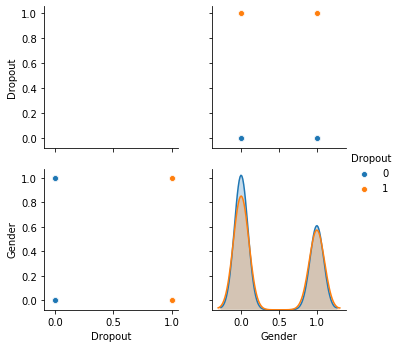

In [159]:
col_0=['Dropout', 'Marital_Status', 'Father_Ed', 'Mother_Ed', 'Housing', 'State', 'Gender']
sns.pairplot(merged_2.dropna()[col_0],hue='Dropout')

Clearly for categorical variables we need to first encode it before running correlation matrix on them.

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


''

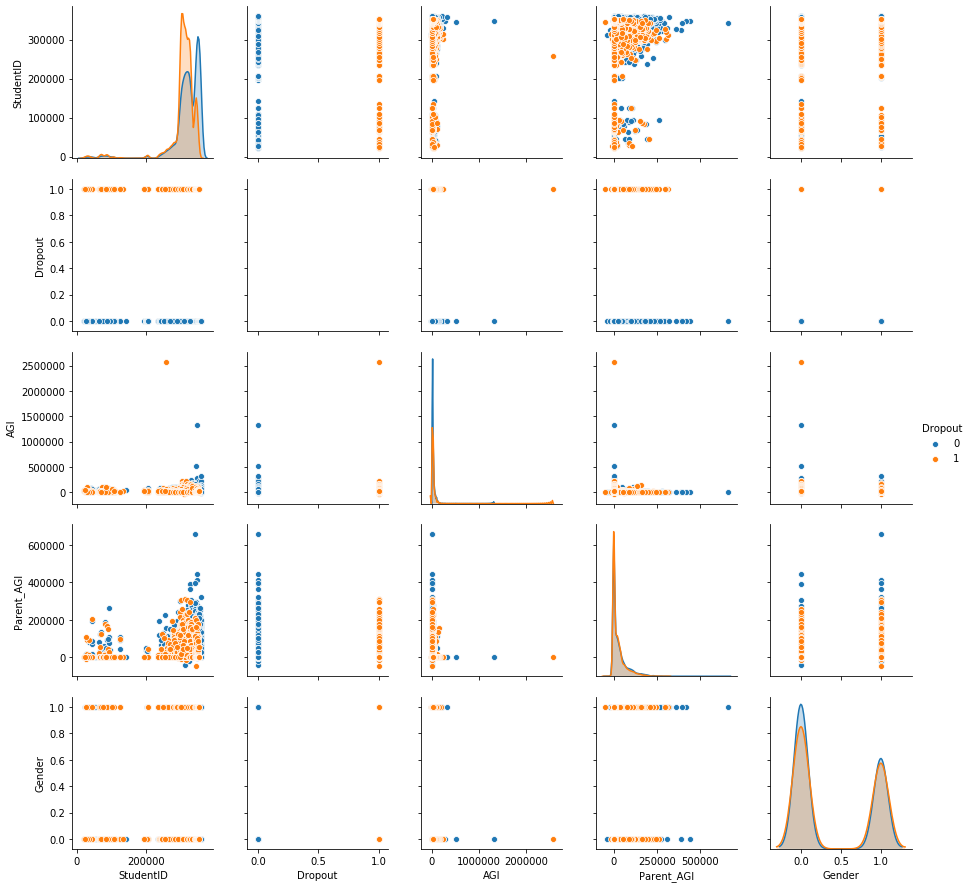

In [127]:
col_1=['StudentID', 'Dropout', 'Marital_Status', 'AGI', 'Parent_AGI',
       'Father_Ed', 'Mother_Ed', 'Housing', 'State', 'Gender']
sns.pairplot(merged_2.dropna()[col_1],hue='Dropout')
;

''

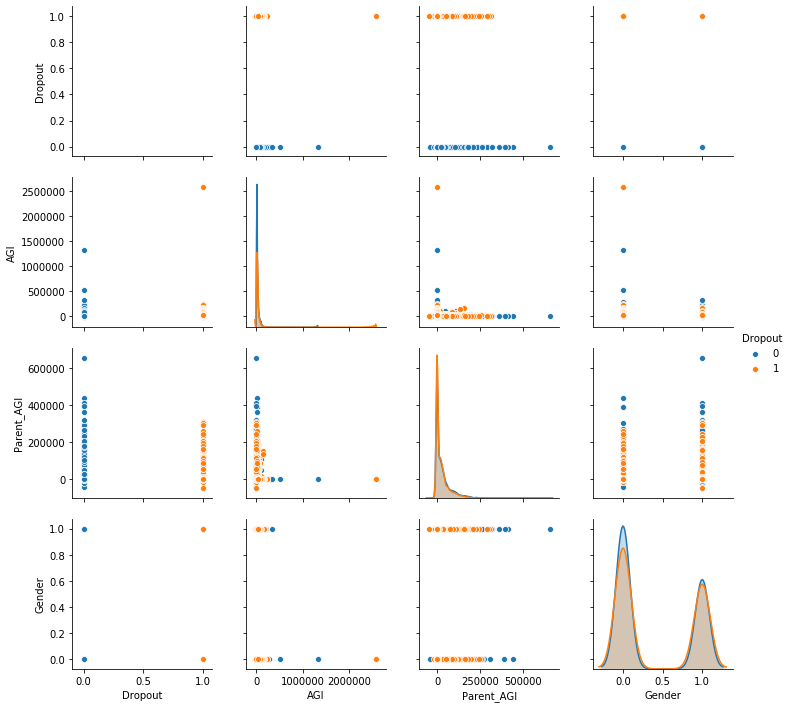

In [131]:
# check for outliers
col_1=['StudentID', 'Dropout', 'Marital_Status', 'AGI', 'Parent_AGI',
       'Father_Ed', 'Mother_Ed', 'Housing', 'State', 'Gender']
sns.pairplot(merged_2.dropna()[['Dropout','AGI','Parent_AGI','Gender',]],hue='Dropout')
;

From the scatter plots, it seems there are also students of both gender that drop out with parent_AGI > 250K. 

''

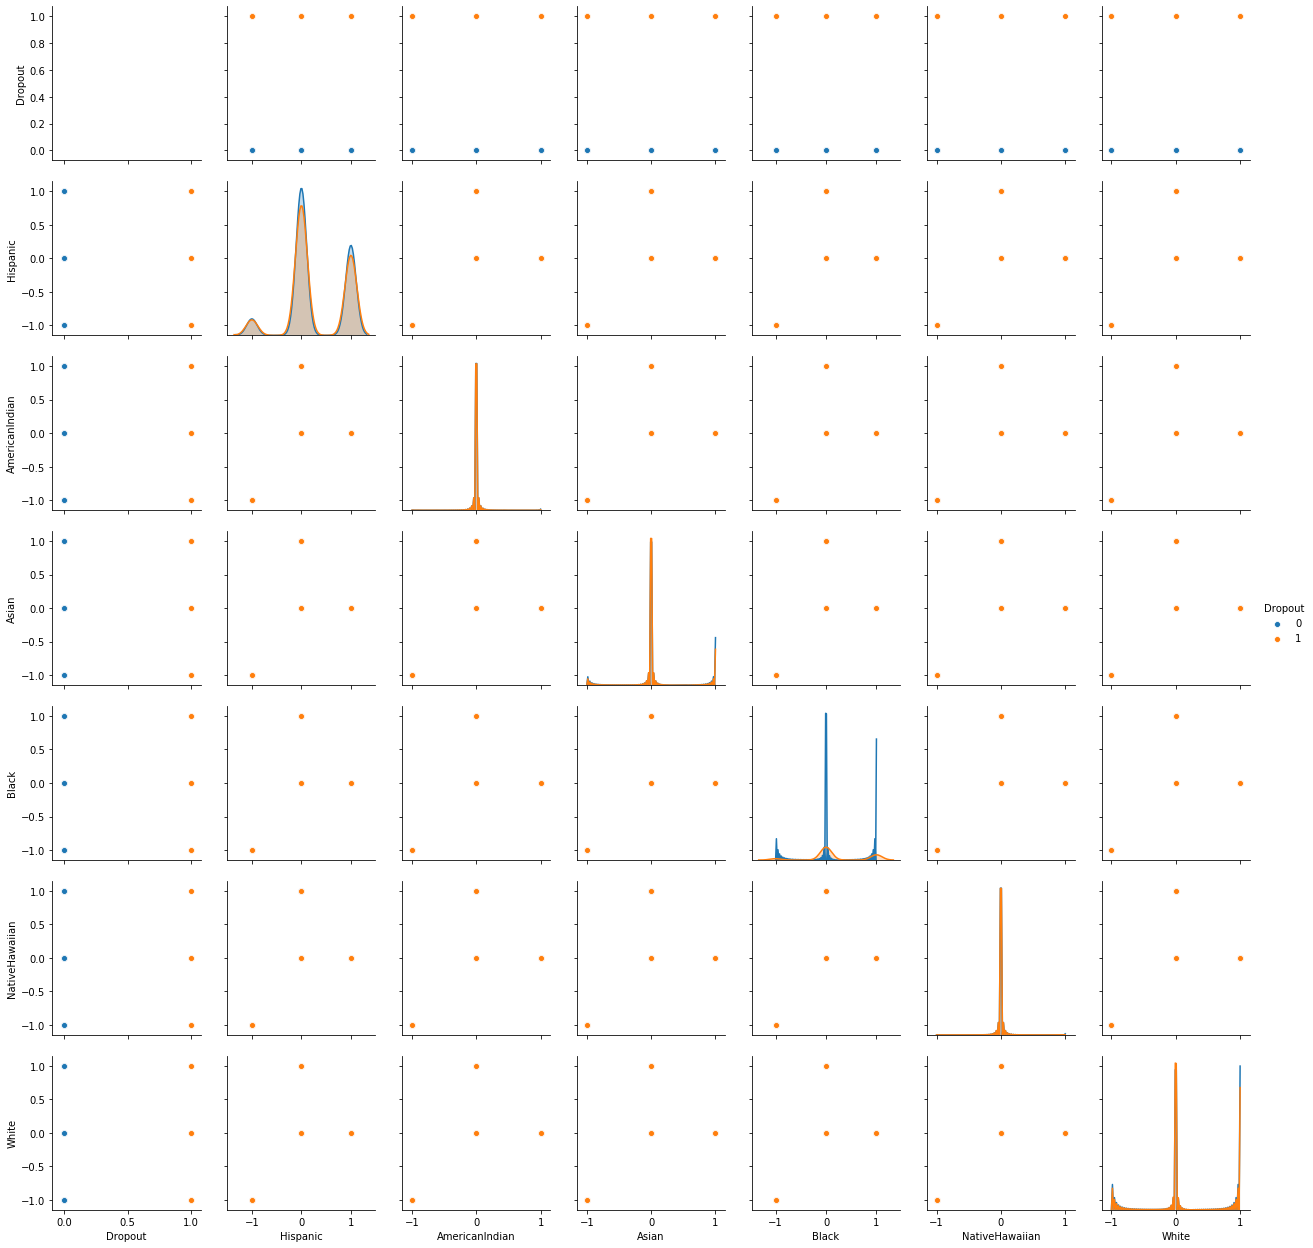

In [132]:
col_2=['Dropout','Hispanic',
       'AmericanIndian', 'Asian', 'Black', 'NativeHawaiian', 'White']

sns.pairplot(merged_2.dropna()[col_2],hue='Dropout')
;

''

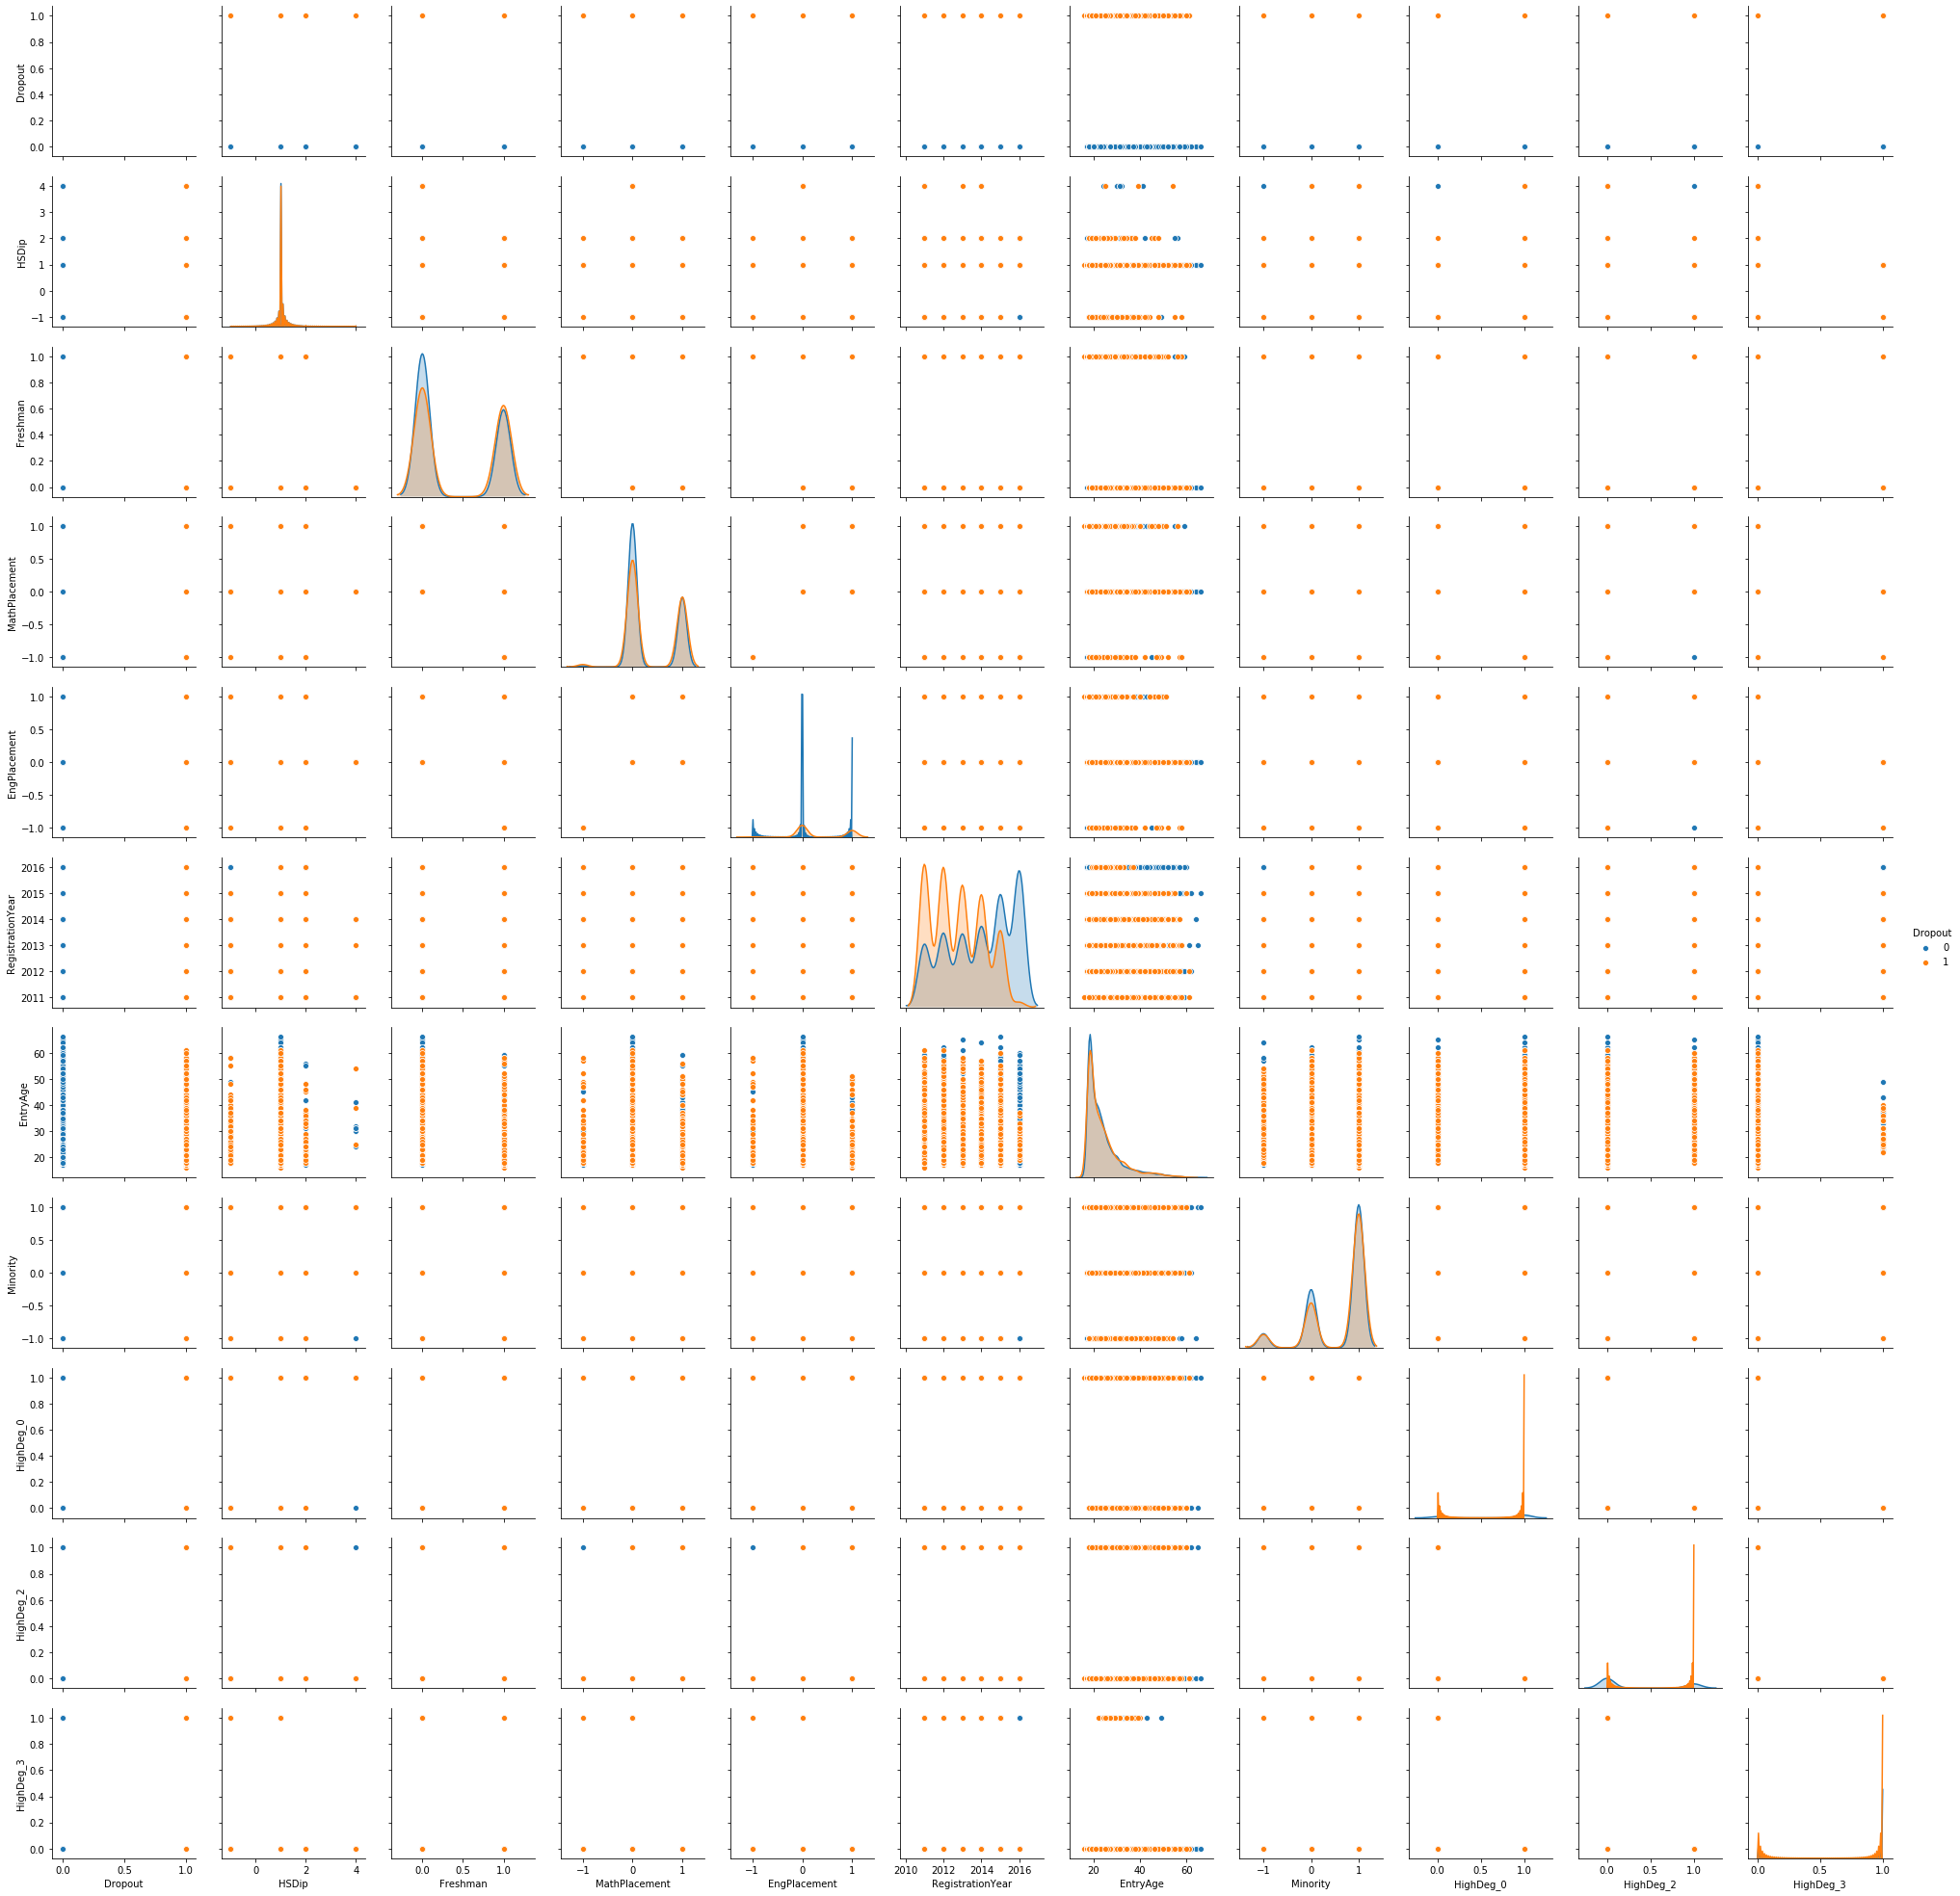

In [129]:
col_3=['Dropout','HSDip',
       'Freshman', 'MathPlacement', 'EngPlacement', 'RegistrationYear',
       'EntryAge', 'Minority', 'HighDeg_0', 'HighDeg_2', 'HighDeg_3']

sns.pairplot(merged_2.dropna()[col_3],hue='Dropout')
;

It seems dropout increases in later registration years (e.g. 2016 has a lot of dropouts of people who are above 40).

People who are math ready are more likely to drop out than those who are not; people who are English ready for college are also more likely to drop out than those who are not. 

''

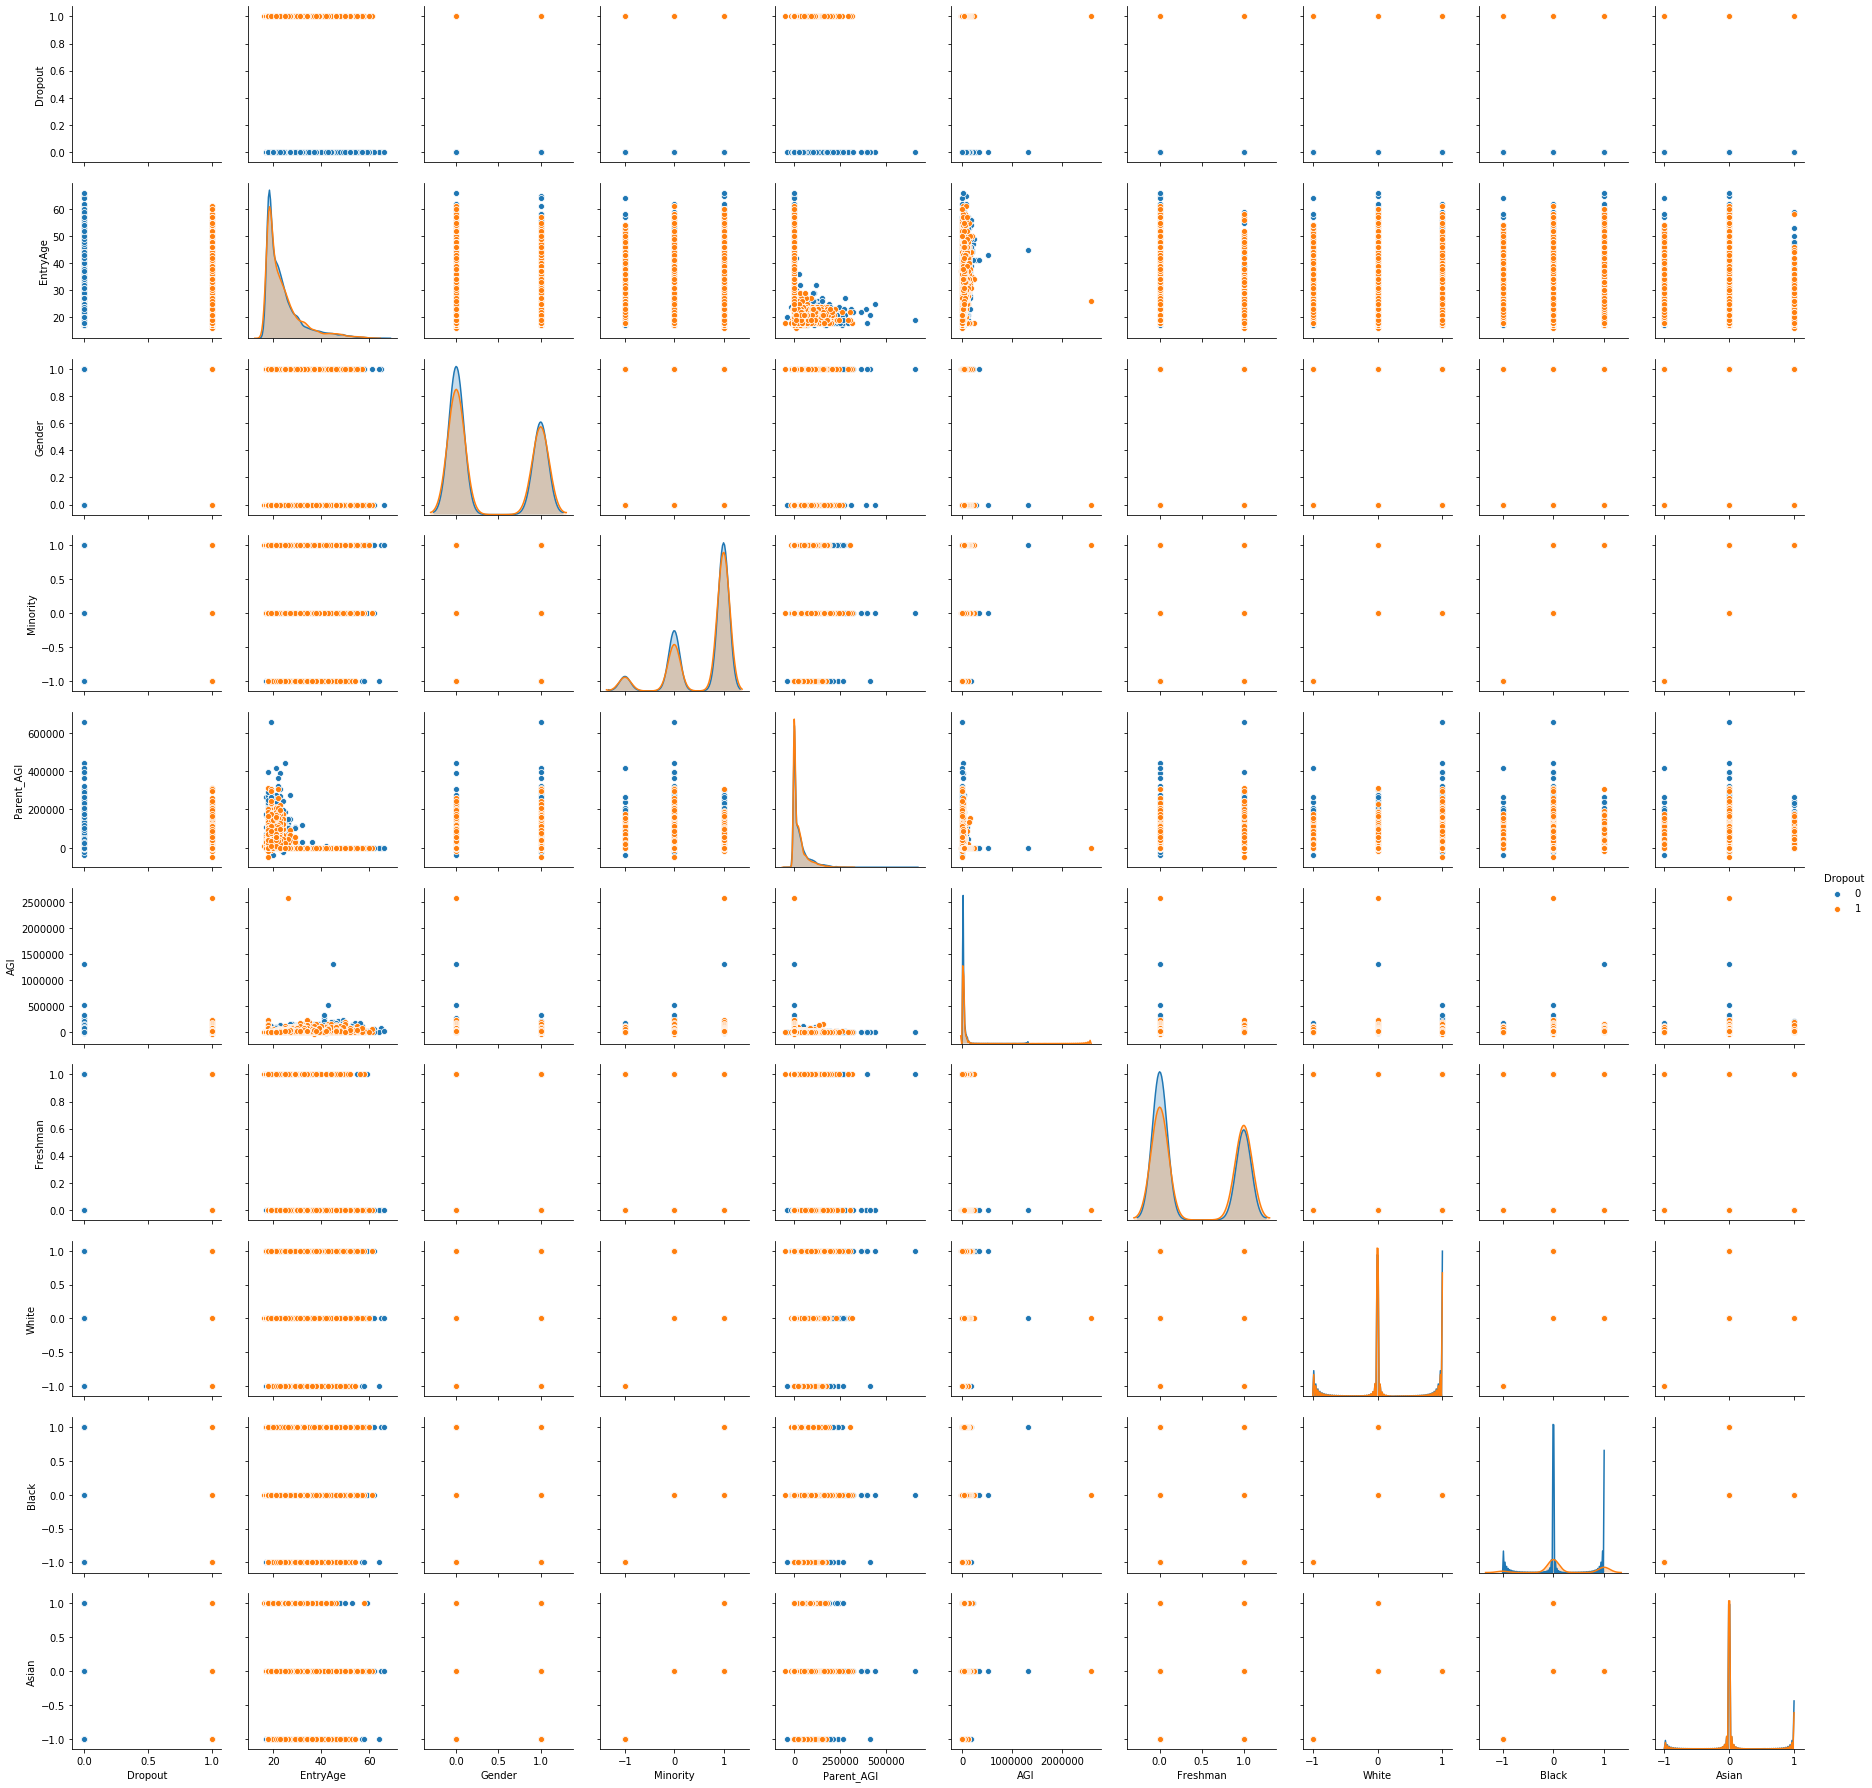

In [130]:
col_4=['Dropout','EntryAge','Gender','Minority','Parent_AGI','AGI','Freshman','White','Black','Asian']
sns.pairplot(merged_2.dropna()[col_4],hue='Dropout')
;

The scatter plot shows older non-whites tend to drop out more than older whites; older blacks tend to have more drop out than elderly non-blacks and similarly for Asians. Older minorities tend to drop out more than older non-minorities.   

Across variables such as gender, freshman or transfer, white, `Parent_AGI` seems to be a great indicator for whether a student will drop out; and the higher `Parents_AGI` is, the more likely the person will drop out. 

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


''

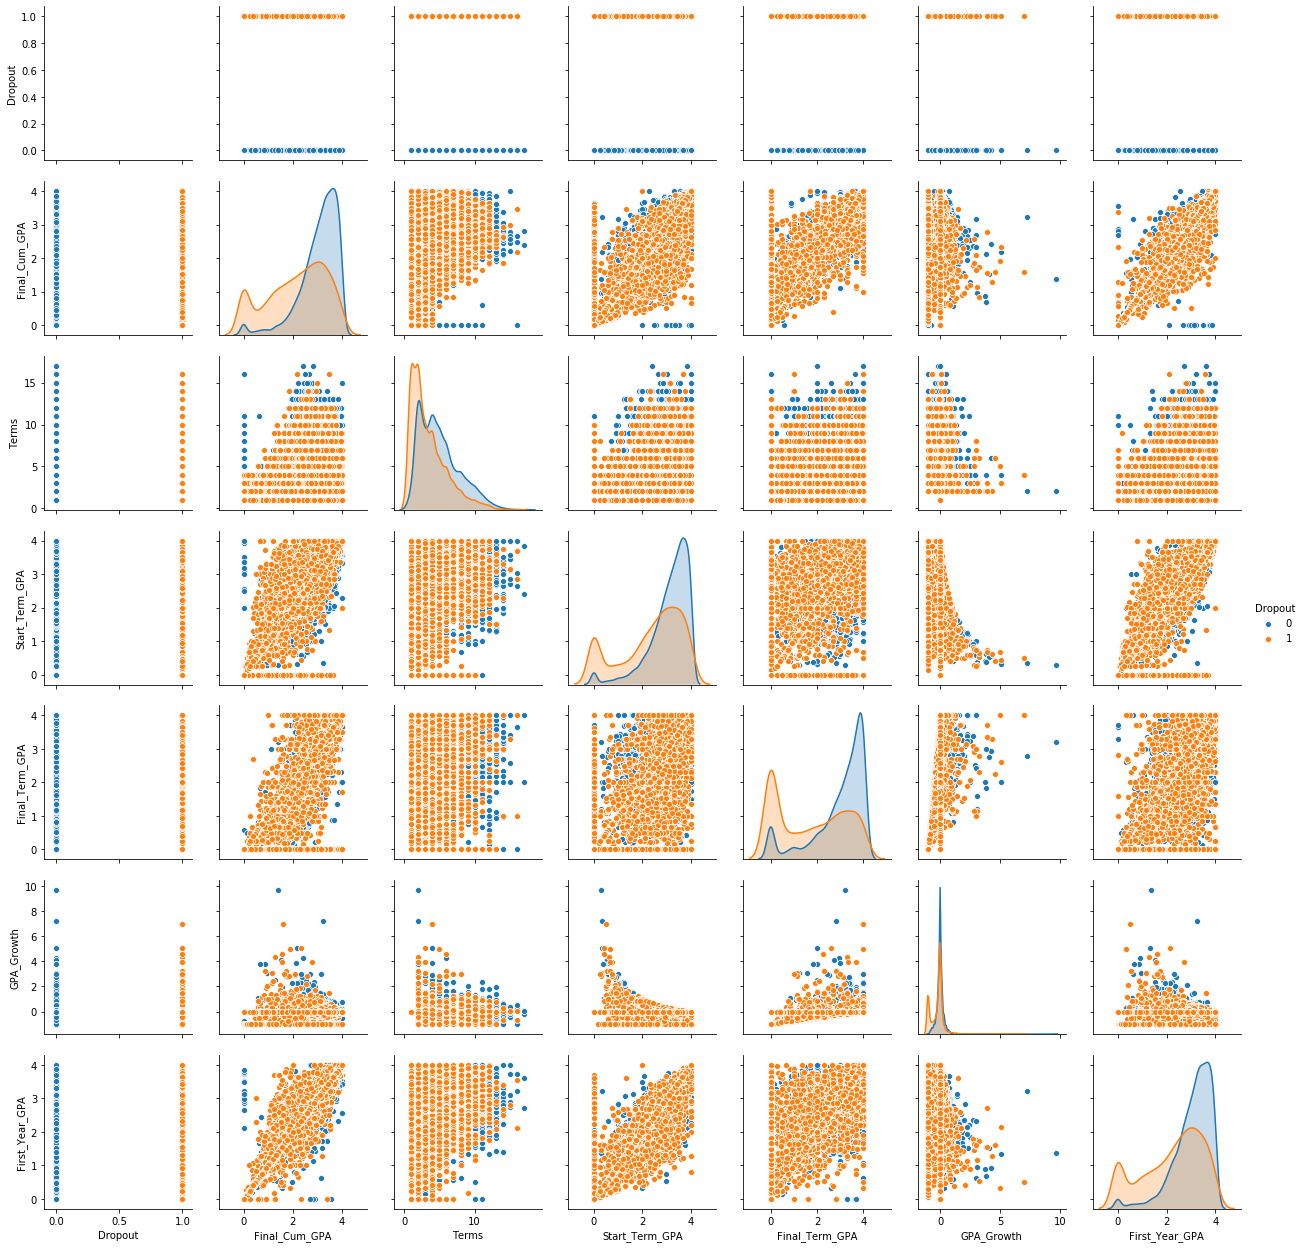

In [165]:
#  look at correlation between the GPA and terms features with dropout
col_5=['Dropout','Final_Cum_GPA','Terms','Start_Term_GPA','Final_Term_GPA','GPA_Growth','First_Year_GPA']
sns.pairplot(merged_2.dropna()[col_5],hue='Dropout')
;

There seems to be an inverse trend between `GPA_Growth` and `Start_Term_GPA` where lower `Start_Term_GPA` correlates with higher `GPA_Growth`; on the other hand, there seems to be a positive trend between `Final_Term_GPA` and `GPA_Growth` where the higher the `Final_Term_GPA`, the higher the `GPA_Growth`. 

Very interestingly, if we look at the correlation between `Final_Term_GPA` for dropouts and non-dropouts, whereas dropouts' `Final_Term_GPA` has a peak around 0, non-dropout's `Final_Term_GPA` has a peak around 4.0 although both have a bimodial distribution. 

There also seems to be some positive relation between `Final_Cum_GPA` and `Final_Term_GPA` and similarly between `Final_Cum_GPA` and `Start_Term_GPA`. 

In all distribution plots that have to do with either `Final_Cum_GPA`, `Start_Term_GPA` or `Final_Term_GPA`, we see a bi-modial distribution for both dropouts and non-dropouts. That is, both dropout and non-dropouts have a lot of 0 GPAs. 

Similarly, in the scatter plots for `Final_Term_GPA` and `Final_Cum_GPA` as well as the one for `Start_Term_GPA` and `Final_Cum_GPA`, we see many outliers either with 0 `Final_Term_GPA` or 0 `Start_Term_GPA`.

In [427]:

merged_2['StudentID'][(merged_2['Final_Cum_GPA']==0) & (merged_2['Start_Term_GPA']==0) & (merged_2['Final_Term_GPA']==0)].count()

573

In [171]:
# look more closely at the rows that have zeros
merged_2['First_Year_GPA'][(merged_2['Final_Cum_GPA']==0) & (merged_2['Start_Term_GPA']==0) & (merged_2['Final_Term_GPA']==0)].describe()

count    573.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: First_Year_GPA, dtype: float64

In [172]:
merged_2[(merged_2['Final_Cum_GPA']==0) & (merged_2['Start_Term_GPA']==0) & (merged_2['Final_Term_GPA']==0)].head()

,StudentID,Dropout,Marital_Status,AGI,Parent_AGI,Father_Ed,Mother_Ed,Housing,State,Gender,...,Minority,HighDeg_0,HighDeg_2,HighDeg_3,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA,GPA_Growth,First_Year_GPA
11,303260,1,Separated,6710.0,0.0,Unknown,Unknown,Off Campus,NJ,0,...,1,1,0,0,0.0,1,0.0,0.0,0.0,0.0
32,298767,1,Single,0.0,24098.0,High School,College,On Campus Housing,NJ,0,...,1,1,0,0,0.0,2,0.0,0.0,0.0,0.0
47,301422,1,Single,16639.0,0.0,High School,College,Off Campus,NJ,1,...,1,1,0,0,0.0,1,0.0,0.0,0.0,0.0
49,300608,1,Single,0.0,37785.0,Unknown,College,With Parent,NJ,1,...,1,1,0,0,0.0,1,0.0,0.0,0.0,0.0
126,303227,1,Single,52364.0,0.0,High School,High School,Off Campus,NJ,1,...,0,1,0,0,0.0,1,0.0,0.0,0.0,0.0


In [177]:
merged_2['Dropout'][(merged_2['Final_Cum_GPA']==0) & (merged_2['Start_Term_GPA']==0) & (merged_2['Final_Term_GPA']==0)].value_counts()

1    486
0     87
Name: Dropout, dtype: int64

In [ ]:
GPAZero=merged_2[(merged_2['Final_Cum_GPA']==0) & (merged_2['Start_Term_GPA']==0) & (merged_2['Final_Term_GPA']==0)]
GPAZeroNoneDrop=GPAZero[GPAZero['Dropout']==0]
GPAZeroDropOut=GPAZero[GPAZero['Dropout']==1]

In [ ]:
# look at the pattern in progress data for GPAZeroNoneDrop, i.e. people who did not drop but GPA is zero
GPAZeroNoneDrop

In [ ]:
# look at the pattern in progress data for GPAZeroDropOut, i.e. people who dropped out and GPA is zero 


In [176]:
# take a closer look at the original progress data
merged_progress[(merged_progress['Final_Cum_GPA']==0) & (merged_2['Start_Term_GPA']==0) & (merged_2['Final_Term_GPA']==0)].head(15)

,StudentID,Major1_Fall_11,DegreeTypeSought_Fall_11,TermGPA_Fall_11,CumGPA_Fall_11,Major1_Spring_12,DegreeTypeSought_Spring_12,TermGPA_Spring_12,CumGPA_Spring_12,Major1_Sum_12,DegreeTypeSought_Sum_12,TermGPA_Sum_12,CumGPA_Sum_12,Major1_Fall_12,DegreeTypeSought_Fall_12,TermGPA_Fall_12,CumGPA_Fall_12,Major1_Spring_13,DegreeTypeSought_Spring_13,TermGPA_Spring_13,CumGPA_Spring_13,Major1_Sum_13,DegreeTypeSought_Sum_13,TermGPA_Sum_13,CumGPA_Sum_13,Major1_Fall_13,DegreeTypeSought_Fall_13,TermGPA_Fall_13,CumGPA_Fall_13,Major1_Spring_14,DegreeTypeSought_Spring_14,TermGPA_Spring_14,CumGPA_Spring_14,Major1_Sum_14,DegreeTypeSought_Sum_14,TermGPA_Sum_14,CumGPA_Sum_14,Major1_Fall_14,DegreeTypeSought_Fall_14,TermGPA_Fall_14,CumGPA_Fall_14,Major1_Spring_15,DegreeTypeSought_Spring_15,TermGPA_Spring_15,CumGPA_Spring_15,Major1_Sum_15,DegreeTypeSought_Sum_15,TermGPA_Sum_15,CumGPA_Sum_15,Major1_Fall_15,DegreeTypeSought_Fall_15,TermGPA_Fall_15,CumGPA_Fall_15,Major1_Spring_16,DegreeTypeSought_Spring_16,TermGPA_Spring_16,CumGPA_Spring_16,Major1_Sum_16,DegreeTypeSought_Sum_16,TermGPA_Sum_16,CumGPA_Sum_16,Major1_Fall_16,DegreeTypeSought_Fall_16,TermGPA_Fall_16,CumGPA_Fall_16,Major1_Spring_17,DegreeTypeSought_Spring_17,TermGPA_Spring_17,CumGPA_Spring_17,Major1_Sum_17,DegreeTypeSought_Sum_17,TermGPA_Sum_17,CumGPA_Sum_17,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA,GPA_Growth,First_Year_GPA
145,259621,13.1209,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,0.0,0.00
759,299740,52.0301,6.0,3.1,3.1,52.0301,6.0,2.75,2.92,52.0301,6.0,3.5,3.04,52.0301,6.0,2.83,2.97,52.0301,6.0,2.77,2.94,52.0301,6.0,2.7,2.92,52.0301,6.0,3.57,3.01,52.0301,6.0,2.33,2.93,NaN,NaN,NaN,NaN,52.0301,6.0,2.75,2.9,52.0301,6.0,2.34,2.82,NaN,NaN,NaN,NaN,26.0101,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11,3.1,0.0,-1.0,2.92
1049,298080,43.0199,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,0.0,0.00
1607,281519,40.0801,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,0.0,0.00
1728,298307,43.0199,6.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,0.0,0.00
1854,281544,NaN,NaN,NaN,NaN,26.0101,6.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,0.0,0.00
1948,303632,NaN,NaN,NaN,NaN,50.0901,6.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0.0,0.0,0.0,0.00
1965,304344,NaN,NaN,NaN,NaN,0.0000,6.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

There are 573 students who have reported 0 for `Final_Cum_GPA`, `Start_Term_GPA` or `Final_Term_GPA`.

In [153]:
# try removing the columns where `Final_Cum_GPA`, `Start_Term_GPA`, 'Final_term_GPA' are zero and look at the correlation matrix again 
new_merged=merged_2[(merged_2['Final_Cum_GPA']!=0) & (merged_2['Start_Term_GPA']!=0) & (merged_2['Final_Term_GPA']!=0)]


''

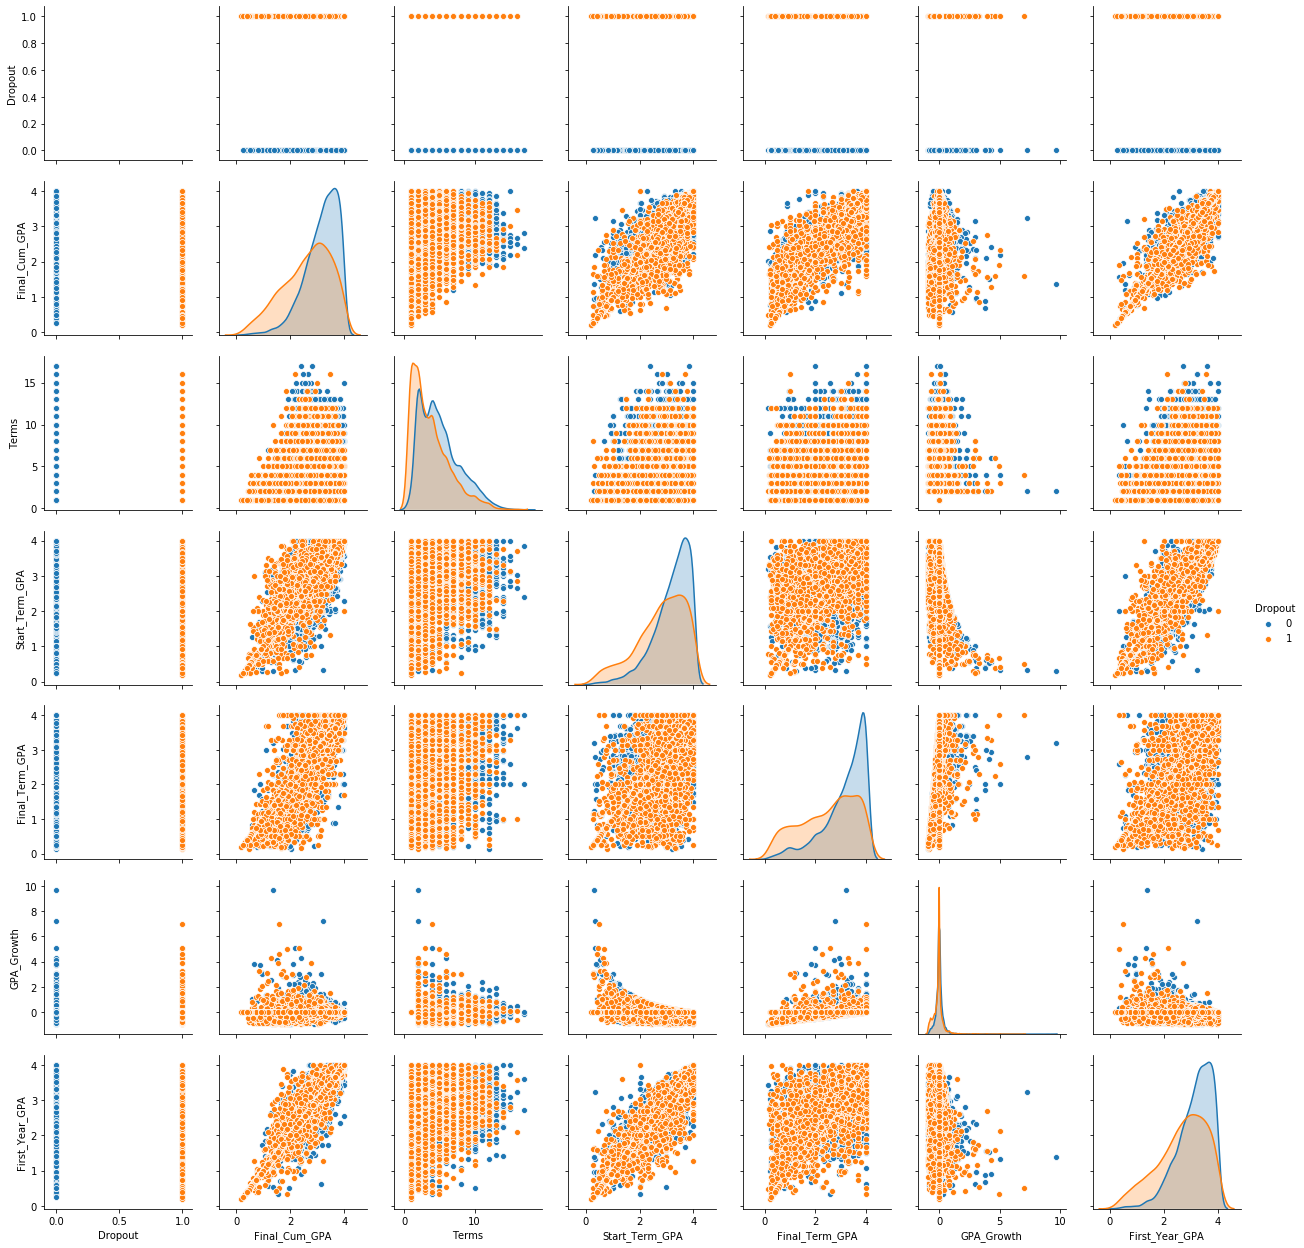

In [167]:
#  look at correlation between the GPA and terms features with dropout
sns.pairplot(new_merged.dropna()[col_5],hue='Dropout')
;

In [154]:
merged_2_copy=new_merged.copy()

In [169]:
merged_2.shape

(12261, 32)

In [168]:
new_merged.shape

(10329, 32)

In [418]:
# final_cum_GPA
merged_2[['Dropout','Final_Cum_GPA']].groupby('Dropout').describe()

Final_Cum_GPA                                                 
                count      mean       std  min    25%   50%   75%  max
Dropout                                                               
0              7527.0  3.079554  0.787457  0.0  2.735  3.26  3.66  4.0
1              4734.0  2.297499  1.239727  0.0  1.410  2.54  3.33  4.0

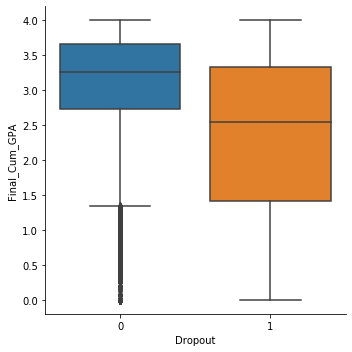

In [404]:
# final_cum_GPA
sns.catplot(x='Dropout',y='Final_Cum_GPA',kind='box',data=merged_2)

Those who drop out tend to have lower final cumulative GPA. The summary statistics shows that the mean final cumulative GPA is much lower for those who drop out than for those who do not. The spread and standard deviation are also larger for those who drop out. 

There are also a group of outliers for non-dropouts whose `Final_Cum_GPA` are lower than 1.5. 

In [153]:
# First_Year_GPA
merged_2[['Dropout','First_Year_GPA']].groupby('Dropout').describe()

First_Year_GPA                                                
                 count      mean       std  min   25%   50%   75%  max
Dropout                                                               
0               7527.0  3.087201  0.784101  0.0  2.72  3.27  3.67  4.0
1               4734.0  2.381105  1.256495  0.0  1.51  2.69  3.42  4.0

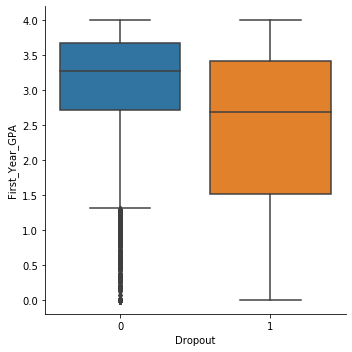

In [154]:
# First_Year_GPA
sns.catplot(x='Dropout',y='First_Year_GPA',kind='box',data=merged_2)

In [419]:
# Start_Term_GPA
merged_2[['Dropout','Start_Term_GPA']].groupby('Dropout').describe()

Start_Term_GPA                                                
                 count      mean       std  min   25%   50%   75%  max
Dropout                                                               
0               7527.0  3.128168  0.826748  0.0  2.80  3.33  3.72  4.0
1               4734.0  2.476234  1.295027  0.0  1.75  2.85  3.53  4.0

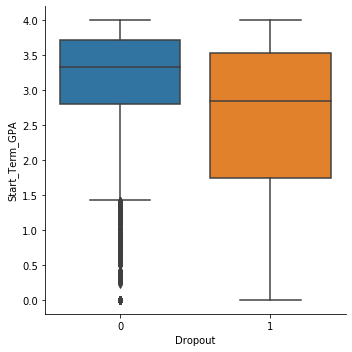

In [405]:
# Start_Term_GPA
sns.catplot(x='Dropout',y='Start_Term_GPA',kind='box',data=merged_2)

In [420]:
# Final_Term_GPA
merged_2[['Dropout','Final_Term_GPA']].groupby('Dropout').describe()

Final_Term_GPA                                                
                 count      mean       std  min   25%   50%   75%  max
Dropout                                                               
0               7527.0  2.989280  1.131072  0.0  2.62  3.35  3.85  4.0
1               4734.0  1.936441  1.515691  0.0  0.00  2.14  3.33  4.0

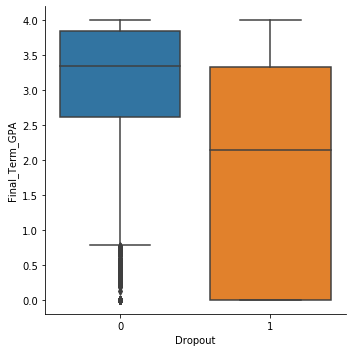

In [406]:
# Final_Term_GPA
sns.catplot(x='Dropout',y='Final_Term_GPA',kind='box',data=merged_2)

In [421]:
#GPA_Growth
merged_2[['Dropout','GPA_Growth']].groupby('Dropout').describe()

GPA_Growth                                    
             count mean std  min   25%  50%   75%  max
Dropout                                               
0           7527.0  inf NaN -1.0 -0.13  0.0  0.11  inf
1           4734.0  inf NaN -1.0 -0.46  0.0  0.00  inf

In [422]:
#terms
merged_2[['Dropout','Terms']].groupby('Dropout').describe()

Terms                                              
          count      mean       std  min  25%  50%  75%   max
Dropout                                                      
0        7527.0  4.965458  2.795896  1.0  3.0  4.0  6.0  17.0
1        4734.0  3.293832  2.523596  1.0  1.0  2.0  5.0  16.0

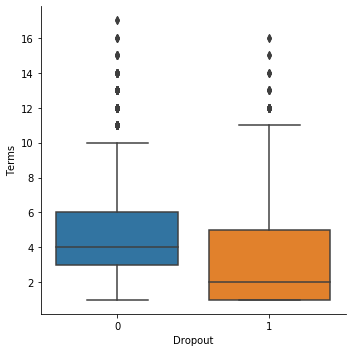

In [423]:
#terms
sns.catplot(x='Dropout',y='Terms',kind='box',data=merged_2)

Those who drop out tend to have fewer terms (both median and mean are smaller for dropouts). There also seem to be a few outliers who have taken more than 12 terms. 

In [163]:
merged_2.shape

(12261, 32)

In [156]:
#merged_2_copy=merged_2.copy()

In [157]:
# #'AGI','Parent_AGI','EntryAge','Final_Term_GPA', 'Start_Term_GPA'
# cols_to_check=['Parent_AGI','Terms','Final_Cum_GPA','First_Year_GPA']

In [158]:
# # use IQR to remove outliers since it is robust against outliers
# Q1=merged_2_copy[cols_to_check].quantile(0.25)
# Q3=merged_2_copy[cols_to_check].quantile(0.75)
# IQR=Q3-Q1
# print(IQR)

Parent_AGI        38804.75
Terms                 4.00
Final_Cum_GPA         1.28
First_Year_GPA        1.26
dtype: float64


In [159]:
# merged_2_copy = merged_2_copy[~((merged_2_copy < (Q1 - 1.5 * IQR)) |(merged_2_copy > (Q3 + 1.5 * IQR))).any(axis=1)]
# merged_2_copy.shape

(10608, 32)

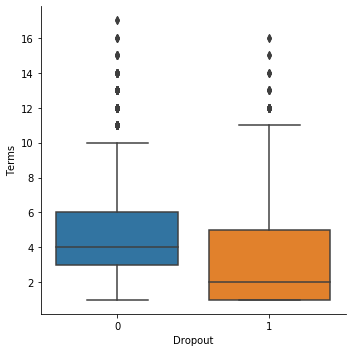

In [160]:
sns.catplot(x='Dropout',y='Terms',kind='box',data=merged_2)

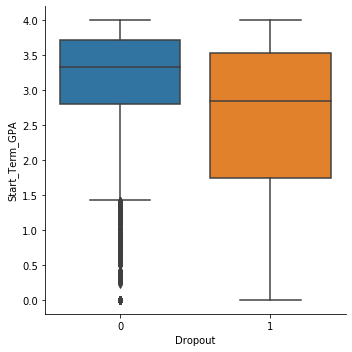

In [164]:
# Start_Term_GPA
sns.catplot(x='Dropout',y='Start_Term_GPA',kind='box',data=merged_2)

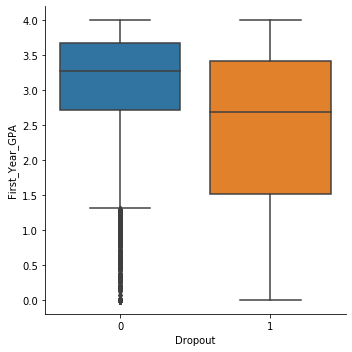

In [161]:
# First_Year_GPA
sns.catplot(x='Dropout',y='First_Year_GPA',kind='box',data=merged_2)

# Missing Data

### 1. numerical missing data

In [155]:
merged_2_copy.isnull().any()

StudentID           False
Dropout             False
Marital_Status       True
AGI                  True
Parent_AGI           True
Father_Ed            True
Mother_Ed            True
Housing              True
State                True
Gender              False
Hispanic            False
AmericanIndian      False
Asian               False
Black               False
NativeHawaiian      False
White               False
HSDip               False
Freshman            False
MathPlacement       False
EngPlacement        False
RegistrationYear    False
EntryAge             True
Minority            False
HighDeg_0           False
HighDeg_2           False
HighDeg_3           False
Final_Cum_GPA       False
Terms               False
Start_Term_GPA      False
Final_Term_GPA      False
GPA_Growth          False
First_Year_GPA      False
dtype: bool

We have missing values in `Marital_Status`, `AGI`, `Parent_AGI`,`Father_Ed`, `Mother_Ed`, `Housing`, `State`, and `EntryAge`. Among them, `EntryAge` has 1 missing value (see Feature 1. EntryAge).

`Marital_Status`,`Father_Ed`,`Mother_Ed`, `Housing`, `State` are categorical variables that haven't been translated into numerical data for regression tasks yet. The other two variables are numerical, i.e.`AGI` and `Parent_AGI`. I will deal with the numerical variables' missing values first.

In [156]:
# check whether there are any patterns for missing values 
merged_2_copy['RegistrationYear'][merged_2_copy['AGI'].isnull()].unique()

array([2011, 2012, 2013, 2014, 2015, 2016])

In [157]:
merged_2_copy['RegistrationYear'][merged_2_copy['Parent_AGI'].isnull()].unique()

array([2011, 2012, 2013, 2014, 2015, 2016])

In [158]:
merged_2_copy.AGI.value_counts()

0.0        3739
1000.0        6
2000.0        6
30000.0       5
90000.0       5
           ... 
55962.0       1
87132.0       1
16027.0       1
47603.0       1
14839.0       1
Name: AGI, Length: 4623, dtype: int64

In [159]:
merged_2_copy.AGI.describe()

count    8.709000e+03
mean     1.397586e+04
std      3.944680e+04
min     -2.432600e+04
25%      0.000000e+00
50%      3.345000e+03
75%      1.734300e+04
max      2.576425e+06
Name: AGI, dtype: float64

Mean of `AGI` is 13262 and Median is 2768.

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([8.297e+03, 3.780e+02, 2.800e+01, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ -24326. ,   62365.7,  149057.4,  235749.1,  322440.8,  409132.5,
         495824.2,  582515.9,  669207.6,  755899.3,  842591. ,  929282.7,
        1015974.4, 1102666.1, 1189357.8, 1276049.5, 1362741.2, 1449432.9,
        1536124.6, 1622816.3, 1709508. , 1796199.7, 1882891.4, 1969583.1,
        2056274.8, 2142966.5, 2229658.2, 2316349.9, 2403041.6, 2489733.3,
        2576425. ]),
 <a list of 30 Patch objects>)

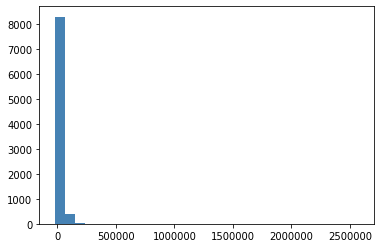

In [160]:
# check whether the distribution of AGI is skewed 
plt.hist(merged_2_copy['AGI'], bins=30, color='steelblue')

The distribution of AGI is highly skewed and we might need to normalize the variable.

However, from the scatter plot in the EDA section, it seems `AGI` is not a very important predicator for dropouts. So I will not include this variable in the features. 

(array([2.000e+00, 3.940e+03, 1.921e+03, 1.179e+03, 5.700e+02, 3.810e+02,
        2.860e+02, 1.540e+02, 1.100e+02, 7.900e+01, 3.400e+01, 2.000e+01,
        1.000e+01, 9.000e+00, 6.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-40260.        , -16996.96666667,   6266.06666667,  29529.1       ,
         52792.13333333,  76055.16666667,  99318.2       , 122581.23333333,
        145844.26666667, 169107.3       , 192370.33333333, 215633.36666667,
        238896.4       , 262159.43333333, 285422.46666667, 308685.5       ,
        331948.53333333, 355211.56666667, 378474.6       , 401737.63333333,
        425000.66666667, 448263.7       , 471526.73333333, 494789.76666667,
        518052.8       , 541315.83333333, 564578.86666667, 587841.9       ,
        611104.93333333, 634367.96666667, 657631.        ]),
 <a list of 30 Patch objects>)

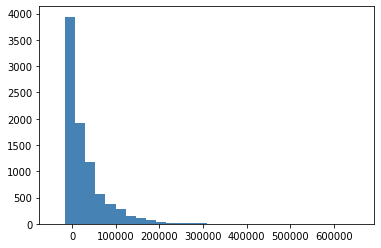

In [161]:
# parent_AGI
plt.hist(merged_2_copy['Parent_AGI'], bins=30, color='steelblue')

In [162]:
merged_2_copy['Parent_AGI'].describe()

count      8709.000000
mean      29403.308072
std       44699.351486
min      -40260.000000
25%           0.000000
50%       12901.000000
75%       40030.000000
max      657631.000000
Name: Parent_AGI, dtype: float64

The distribution of `Parent_AGI` looks more useful but why would this variable have negative values? Let's find out.

In [163]:
merged_2_copy['Parent_AGI'][merged_2_copy['Parent_AGI']<0]

116      -869.0
347    -12240.0
903    -10918.0
3010   -40260.0
3536   -15469.0
5475   -20471.0
5509    -2155.0
5535    -2939.0
7715    -6351.0
9550    -5069.0
Name: Parent_AGI, dtype: float64

I searched on Google and it seems possible that one would end up with a negative Adjusted Gross Income, so I will keep the negative records for now.

In [164]:
merged_2_copy['Parent_AGI'].isnull().sum()

1620

In [165]:
#percentage of missing values for parent AGI
(merged_2_copy['Parent_AGI'].isnull().sum())/len(merged_2_copy)

0.15683996514667442

From the scatterplot we know `Parent_AGI` is an important predicator for dropouts. And since the distribution of parents' AGI is very much skewed, it won't make sense to impute the missing values with the mean, I will impute the missing values with median. 

In [166]:
# before imputing missing values for Parent_AGI, create a copy of merged_2 so that
# we only need to run on the copy from this line below
merged_2A=merged_2_copy.copy()

In [167]:
median=merged_2A['Parent_AGI'].median()

In [168]:
# impute missing values in parent_AGI with median
merged_2A['Parent_AGI_Imp']=merged_2A['Parent_AGI']
merged_2A['Parent_AGI_Imp'].fillna(median, inplace=True)

In [169]:
#double check 
merged_2A['Parent_AGI_Imp'].isnull().sum()

0

In [170]:
merged_2A['Parent_AGI_Imp'].describe()

count     10329.000000
mean      26815.086649
std       41480.677822
min      -40260.000000
25%           0.000000
50%       12901.000000
75%       33688.000000
max      657631.000000
Name: Parent_AGI_Imp, dtype: float64

### 2. Categorical Variables Missing Data

`Marital_Status`,`Father_Ed`,`Mother_Ed`, `Housing`, `State`

It would be very helpful to look at the correlation of these variables with others in order to decide whether it is worth imputing the variable (e.g. when for instance, the missing rate is above 10%)

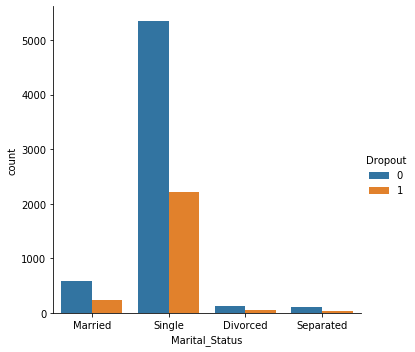

In [171]:
# Marital_Status
sns.catplot(x='Marital_Status', kind='count',hue='Dropout', data=merged_2A)

The barplot shows in all levels of marital status, there are more non-dropouts than dropouts. This might be because our dropout labels are highly unbalanced (many more non-dropouts than dropouts).

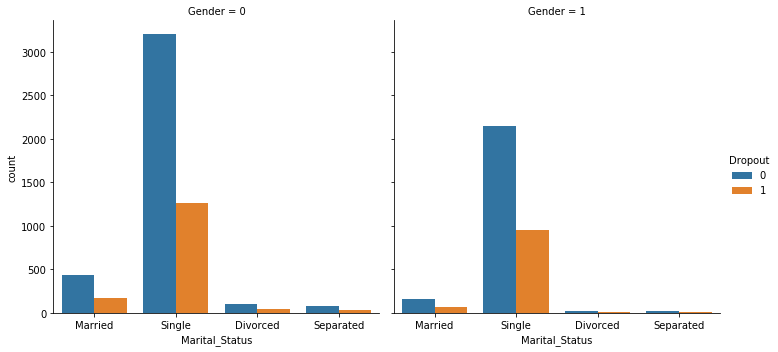

In [172]:
sns.catplot(x='Marital_Status',kind='count',hue='Dropout',col='Gender',data=merged_2A)

That there are more non-dropouts than dropouts across marital status is also true across gender.

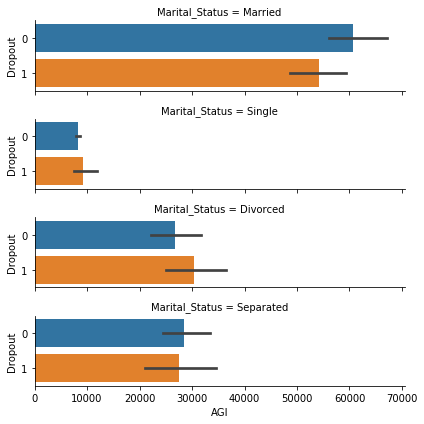

In [173]:
sns.catplot(x='AGI', y='Dropout',row='Marital_Status', 
            kind='bar',orient='h',height=1.5, aspect=4,data=merged_2A)

The bar plot above shows that among the married students, those who drop out tend to have less adjusted gross income. For single students, it seems drop outs tend to have slightly higher AGIs. For those who are separated, dropouts tend to have smaller AGI; different from the divorced, where dropouts tend to have more AGI.

Since separted and divorced have drastically different relation with AGI (in terms of dropouts). I will keep these two groups separated instead of combining them together into one category.

In [174]:
merged_2A.Marital_Status.unique()

array(['Married', nan, 'Single', 'Divorced', 'Separated'], dtype=object)

In [175]:
merged_2A.Marital_Status.isnull().sum()

1620

In [176]:
print("percentage of missing values in Marital_Status in total is {}". format((1841)/len(merged_2A)))

percentage of missing values in Marital_Status in total is 0.17823603446606642


In [177]:
merged_2A.Marital_Status.value_counts()

Single       7563
Married       826
Divorced      178
Separated     142
Name: Marital_Status, dtype: int64

In [178]:
merged_2A.Marital_Status.describe()

count       8709
unique         4
top       Single
freq        7563
Name: Marital_Status, dtype: object

In [179]:
#most common category 
Mode=merged_2A.Marital_Status.mode()[0]

In [180]:
Mode

'Single'

For `Marital_Status`, I will impute the missing values with the mode.

In [181]:
# replace the null values with the mode
merged_2A['Marital_Status_Imp']=merged_2A['Marital_Status']
merged_2A['Marital_Status_Imp'].fillna(Mode,inplace=True)
merged_2A['Marital_Status_Imp'].isnull().sum()

0

In [182]:
# father_ed
merged_2A['Father_Ed'].isnull().sum()

1713

In [183]:
merged_2A['Father_Ed'].value_counts()

High School      3819
College          2472
Unknown          1320
Middle School    1005
Name: Father_Ed, dtype: int64

In [184]:
print("percentage of missing values in Father_Ed in total is {}". format((1598+1968)/len(merged_2A)))

percentage of missing values in Father_Ed in total is 0.34524155290928454


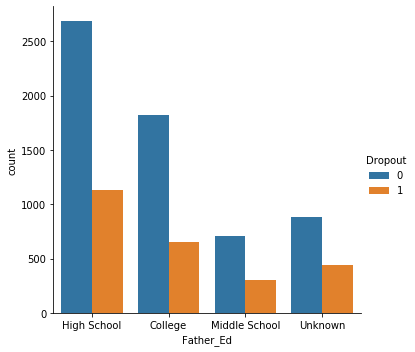

In [185]:
# look at the plot
sns.catplot(x='Father_Ed', kind='count',hue='Dropout', data=merged_2A)

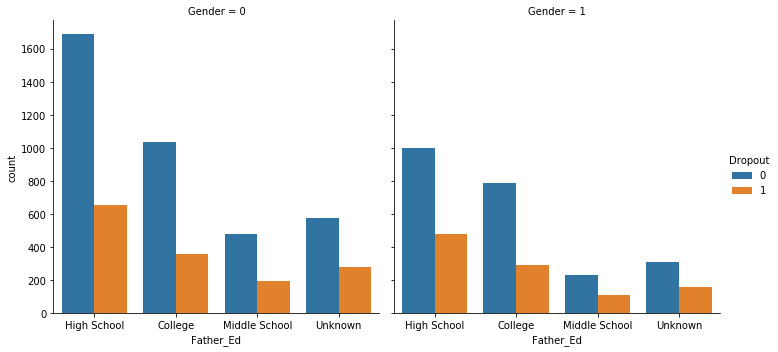

In [186]:
sns.catplot(x='Father_Ed',kind='count',hue='Dropout',col='Gender',data=merged_2A)

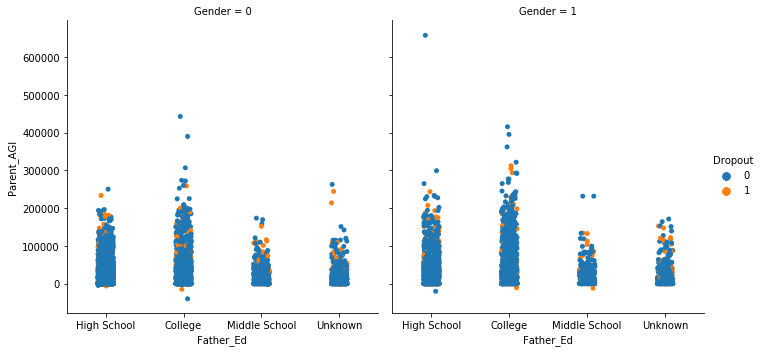

In [187]:
sns.catplot(x='Father_Ed',y='Parent_AGI',hue='Dropout',col='Gender',data=merged_2A)

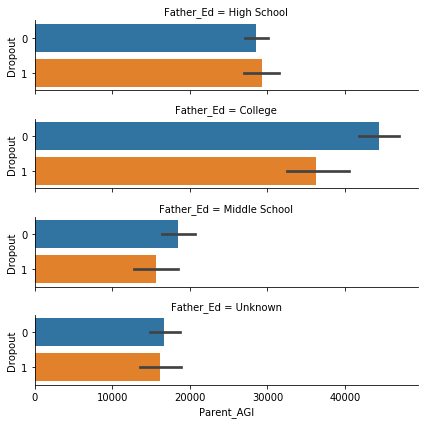

In [188]:
sns.catplot(x='Parent_AGI', y='Dropout',row='Father_Ed', 
            kind='bar',orient='h',height=1.5, aspect=4,data=merged_2A)

Across all levels of father's education, non-dropouts tend to have higher parent AGI than dropouts. 

I will impute the missing values in `Father_Ed` by replacing the null values with the existing `Unknown` category since the total missing values (if including the unknown) are high (30%), if I replace all of them with the mode, it will greatly skew the data. Thus, I will use the 'unknown' category to best preserve the data as it is.

In [189]:
# replace missing values in Father Ed with 'unknown'
merged_2A['Father_Ed_Imp']=merged_2A['Father_Ed']
merged_2A['Father_Ed_Imp'].fillna('Unknown', inplace=True)
merged_2A['Father_Ed_Imp'].isnull().sum()

0

In [190]:
# check the value counts
merged_2A['Father_Ed_Imp'].value_counts()

High School      3819
Unknown          3033
College          2472
Middle School    1005
Name: Father_Ed_Imp, dtype: int64

In [191]:
#mother_ed
merged_2A['Mother_Ed'].isnull().sum()

1879

In [192]:
merged_2A['Mother_Ed'].value_counts()

High School      3744
College          2454
Unknown          1286
Middle School     966
Name: Mother_Ed, dtype: int64

In [193]:
print("percentage of missing values in Mother_Ed in total is {}". format((2161+1535)/len(merged_2A)))

percentage of missing values in Mother_Ed in total is 0.35782747603833864


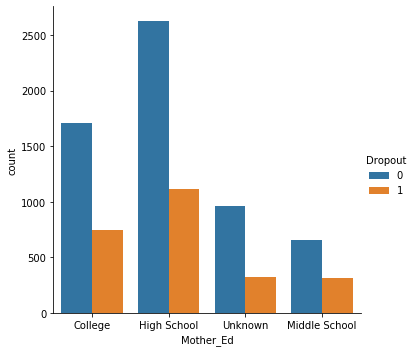

In [194]:
# look at the plot
sns.catplot(x='Mother_Ed', kind='count',hue='Dropout', data=merged_2A)

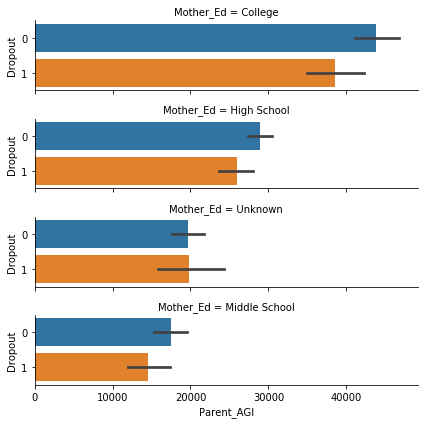

In [195]:
sns.catplot(x='Parent_AGI', y='Dropout',row='Mother_Ed', 
            kind='bar',orient='h',height=1.5, aspect=4,data=merged_2A)

Similarly, because the missing values (if including the unknown category) is high (30.1%). I will impute the missing values with the unknown category so that we don't skew the data too much.

In [196]:
# replace missing values in Father Ed with 'unknown'
merged_2A['Mother_Ed_Imp']=merged_2A['Mother_Ed']
merged_2A['Mother_Ed_Imp'].fillna('Unknown', inplace=True)
merged_2A['Mother_Ed_Imp'].isnull().sum()

0

In [197]:
# check the value counts
merged_2A['Mother_Ed_Imp'].value_counts()

High School      3744
Unknown          3165
College          2454
Middle School     966
Name: Mother_Ed_Imp, dtype: int64

In [198]:
# Housing
merged_2A['Housing'].value_counts()

Off Campus           4045
With Parent          3501
On Campus Housing    1140
Name: Housing, dtype: int64

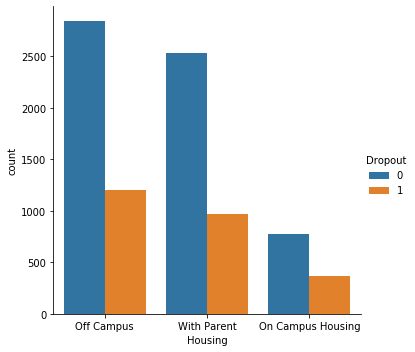

In [199]:
sns.catplot(x='Housing',kind='count',hue='Dropout',data=merged_2A)

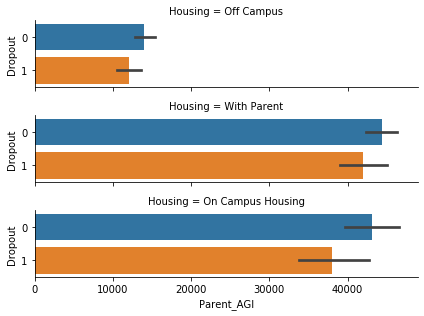

In [200]:
#sns.catplot(x='Parent_AGI',kind='count',hue='Dropout',col='Housing',data=merged_2A)
sns.catplot(x='Parent_AGI',y='Dropout',row='Housing', 
            kind='bar',orient='h',height=1.5, aspect=4,data=merged_2A)

Across all levels of housing, dropouts' Parent AGI is smaller than non-dropouts. 

In [201]:
merged_2A['Housing'].isnull().sum()

1643

In [202]:
print("percentage of missing values in Housing is {}". format((1865)/len(merged_2A)))

percentage of missing values in Housing is 0.1805595895052764


In [203]:
#look at housing mode
merged_2A.Housing.mode()

0    Off Campus
dtype: object

In [204]:
mode2=merged_2A.Housing.mode()[0]
mode2

'Off Campus'

In [205]:
#impute the missing value in housing with mode
merged_2A['Housing_Imp']=merged_2A['Housing']
merged_2A['Housing_Imp'].fillna(mode2,inplace=True)
merged_2A.Housing_Imp.isnull().sum()


0

In [206]:
#check again value counts
merged_2A.Housing_Imp.value_counts()

Off Campus           5688
With Parent          3501
On Campus Housing    1140
Name: Housing_Imp, dtype: int64

In [207]:
#State
merged_2A.State.value_counts()

NJ    9978
NY      99
FL      24
CA      13
MD      12
PA      12
TX       9
GA       8
MA       6
WI       6
VA       5
NC       4
AZ       4
OH       4
MN       3
IA       3
IL       3
SC       3
AL       3
IN       2
KS       2
CT       2
RI       2
NV       2
MI       2
DC       2
NM       2
WA       2
CO       2
KY       1
ME       1
UT       1
LA       1
OK       1
SD       1
MO       1
DE       1
NE       1
TN       1
Name: State, dtype: int64

Interesting, the majority of the students seem to come from the state of NJ.

In [208]:
merged_2A.State.isnull().sum()

100

Per the definition of `State` variable in the data dictionary that international students' state information is left blank. It is plausible that some of the missing records might indicate international students.  

We can check this by looking at the missing records' dropout rates.

In [209]:
merged_2A[merged_2A['State'].isnull()].groupby('Dropout').count()

,StudentID,Marital_Status,AGI,Parent_AGI,Father_Ed,Mother_Ed,Housing,State,Gender,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,HSDip,Freshman,MathPlacement,EngPlacement,RegistrationYear,EntryAge,Minority,HighDeg_0,HighDeg_2,HighDeg_3,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA,GPA_Growth,First_Year_GPA,Parent_AGI_Imp,Marital_Status_Imp,Father_Ed_Imp,Mother_Ed_Imp,Housing_Imp
Dropout,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,47,3,3,3,3,3,3,0,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
1,53,0,0,0,0,0,0,0,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53


In [210]:
print("percentage of missing values in State is {}". format((103)/len(merged_2A)))

percentage of missing values in State is 0.00997192370994288


In [211]:
merged_2A.State.mode()

0    NJ
dtype: object

I don't think it is helpful to impute the missing values in State by the mode (NJ) because we know for instance, that these students could be international although we can't find a way to ascertain who among them are actually international. As such, I will impute the missing state with unknown. 

In [212]:
merged_2A['State_Imp']=merged_2A['State']
merged_2A['State_Imp'].fillna('Unknown', inplace=True)
merged_2A['State_Imp'].isnull().sum()

0

In [213]:
merged_2A['State_Imp'].value_counts()

NJ         9978
Unknown     100
NY           99
FL           24
CA           13
MD           12
PA           12
TX            9
GA            8
MA            6
WI            6
VA            5
NC            4
AZ            4
OH            4
MN            3
IA            3
IL            3
SC            3
AL            3
RI            2
IN            2
KS            2
CT            2
CO            2
NV            2
MI            2
DC            2
NM            2
WA            2
TN            1
UT            1
ME            1
OK            1
LA            1
SD            1
MO            1
NE            1
DE            1
KY            1
Name: State_Imp, dtype: int64

In [214]:
merged_2A.shape

(10329, 38)

In [215]:
# drop the original colomns here
dropped=['Marital_Status','Father_Ed','Mother_Ed', 'Housing', 'State']
merged_2A=merged_2A.drop(columns=dropped, axis=1)


In [216]:
# make a copy
merged_2B=merged_2A.copy()

In [217]:
merged_2B.shape

(10329, 33)

### 3. clean variables with missing values numbered as -1

`Hispanic`, `AmericanIndian`, `Asian`, `White`,`Black`,`Minority`,`NativeHawaiian` (all the race variables) and `MathPlacement`, `EnglishPlacement` (Math and English college readiness)  

These variables also contain missing values where missing values are numbered as -1. I will clean them because -1 won't be making sense when we use it to do prediction.

In [218]:
merged_2B.Hispanic.value_counts()

 0    6292
 1    3302
-1     735
Name: Hispanic, dtype: int64

In [219]:
merged_2B.AmericanIndian.value_counts()

 0    9574
-1     735
 1      20
Name: AmericanIndian, dtype: int64

In [220]:
merged_2B.Asian.value_counts()

 0    8617
 1     977
-1     735
Name: Asian, dtype: int64

In [221]:
merged_2B.White.value_counts()

 0    6887
 1    2707
-1     735
Name: White, dtype: int64

In [222]:
merged_2B.Black.value_counts()

 0    7532
 1    2062
-1     735
Name: Black, dtype: int64

In [223]:
merged_2B.Minority.value_counts()

 1    6378
 0    3216
-1     735
Name: Minority, dtype: int64

In [224]:
merged_2B.NativeHawaiian.value_counts()

 0    9577
-1     735
 1      17
Name: NativeHawaiian, dtype: int64

It's interesting that the number of missing values are the same for all the race variables. Let's take a closer look.

In [225]:
race_miss=merged_2B[merged_2B['Black']==-1]

In [226]:
race_miss.describe()

,StudentID,Dropout,AGI,Parent_AGI,Gender,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,HSDip,Freshman,MathPlacement,EngPlacement,RegistrationYear,EntryAge,Minority,HighDeg_0,HighDeg_2,HighDeg_3,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA,GPA_Growth,First_Year_GPA,Parent_AGI_Imp
count,735.000000,735.000000,601.000000,601.000000,735.000000,735.0,735.0,735.0,735.0,735.0,735.0,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.0,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,314793.508844,0.356463,16031.204659,25529.801997,0.391837,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.963265,0.308844,0.118367,0.084354,2013.297959,26.673469,-1.0,0.576871,0.413605,0.009524,3.206680,4.685714,3.257483,3.189034,0.006748,3.218939,23227.408163
std,42819.318195,0.479280,23780.364693,45537.783374,0.488493,0.0,0.0,0.0,0.0,0.0,0.0,0.317535,0.462331,0.507038,0.479512,1.601152,9.454151,0.0,0.494392,0.492815,0.097190,0.706915,2.749882,0.746110,0.904358,0.360299,0.714952,41459.884928
min,37639.000000,0.000000,0.000000,-40260.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,0.000000,-1.000000,-1.000000,2011.000000,16.000000,-1.0,0.000000,0.000000,0.000000,0.330000,1.000000,0.280000,0.200000,-0.930000,0.330000,-40260.000000
25%,306153.500000,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.000000,0.000000,0.000000,0.000000,2012.000000,20.000000,-1.0,0.000000,0.000000,0.000000,2.865000,2.000000,2.930000,2.775000,-0.090000,2.905000,0.000000
50%,320146.000000,0.000000,7254.000000,0.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.000000,0.000000,0.000000,0.000000,2013.000000,23.000000,-1.0,1.000000,0.000000,0.000000,3.420000,4.000000,3.500000,3.500000,0.000000,3.420000,12901.000000
75%,331769.500000,1.000000,21447.000000,33362.000000,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.000000,1.000000,0.000000,0.000000,2015.000000,30.000000,-1.0,1.000000,1.000000,0.000000,3.730000,6.000000,3.805000,3.895000,0.080000,3.750000,25403.000000
max,359153.000000,1.000000,170889.000000,415463.000000,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.000000,1.000000,1.000000,1.000000,2016.000000,64.000000,-1.0,1.000000,1.000000,1.000000,4.000000,14.000000,4.000000,4.000000,3.260000,4.000000,415463.000000


In [227]:
print("percentage of missing values in State is {}". format((842)/len(merged_2A)))

percentage of missing values in State is 0.08151805595895052


It seems there are 842 records that have no race information whatsoever. And it won't make sense to impute the missing race values with the mode within that racial category because by doing so, all the imputed records would be replaced by the dominant (more frequent) value within that racial category. So that although statistically, they can add information to the dataset, in reality, they will belong to no existing racial category and this won't make sense in pratice. As a result, I will the records where all the race information is missing. 

In [228]:
# drop the 842 records. 
merged_2B.drop(merged_2B[merged_2B['Black']==-1].index, inplace=True)


In [229]:
# double check
race_col=['Hispanic', 'AmericanIndian', 'Asian', 'White','Black','Minority','NativeHawaiian'] 
for race_cat in race_col:
    print(merged_2B[race_cat].value_counts())

0    6292
1    3302
Name: Hispanic, dtype: int64
0    9574
1      20
Name: AmericanIndian, dtype: int64
0    8617
1     977
Name: Asian, dtype: int64
0    6887
1    2707
Name: White, dtype: int64
0    7532
1    2062
Name: Black, dtype: int64
1    6378
0    3216
Name: Minority, dtype: int64
0    9577
1      17
Name: NativeHawaiian, dtype: int64


In [230]:
merged_2B.columns

Index(['StudentID', 'Dropout', 'AGI', 'Parent_AGI', 'Gender', 'Hispanic',
       'AmericanIndian', 'Asian', 'Black', 'NativeHawaiian', 'White', 'HSDip',
       'Freshman', 'MathPlacement', 'EngPlacement', 'RegistrationYear',
       'EntryAge', 'Minority', 'HighDeg_0', 'HighDeg_2', 'HighDeg_3',
       'Final_Cum_GPA', 'Terms', 'Start_Term_GPA', 'Final_Term_GPA',
       'GPA_Growth', 'First_Year_GPA', 'Parent_AGI_Imp', 'Marital_Status_Imp',
       'Father_Ed_Imp', 'Mother_Ed_Imp', 'Housing_Imp', 'State_Imp'],
      dtype='object')

In [231]:
merged_2B.shape

(9594, 33)

In [232]:
# check mathplacement and EngPlacement
merged_2B.MathPlacement.isnull().sum()

0

In [233]:
merged_2B.EngPlacement.isnull().sum()

0

In [234]:
print(merged_2B.MathPlacement.value_counts())
print(merged_2B.EngPlacement.value_counts())

 0    6302
 1    2889
-1     403
Name: MathPlacement, dtype: int64
 0    7171
 1    2020
-1     403
Name: EngPlacement, dtype: int64


In [235]:
#check the 458 records
merged_2B[merged_2B['MathPlacement']==-1].describe()

,StudentID,Dropout,AGI,Parent_AGI,Gender,Hispanic,AmericanIndian,Asian,Black,NativeHawaiian,White,HSDip,Freshman,MathPlacement,EngPlacement,RegistrationYear,EntryAge,Minority,HighDeg_0,HighDeg_2,HighDeg_3,Final_Cum_GPA,Terms,Start_Term_GPA,Final_Term_GPA,GPA_Growth,First_Year_GPA,Parent_AGI_Imp
count,403.000000,403.000000,72.000000,72.000000,403.000000,403.000000,403.0,403.000000,403.000000,403.0,403.000000,403.000000,403.0,403.0,403.0,403.000000,403.000000,403.000000,403.000000,403.0,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000
mean,327597.374690,0.746898,11550.930556,36337.944444,0.461538,0.178660,0.0,0.136476,0.089330,0.0,0.387097,0.652605,1.0,-1.0,-1.0,2014.119107,27.749380,0.404467,0.982630,0.0,0.017370,3.458784,1.734491,3.499454,3.432556,-0.015931,3.459504,17088.245658
std,45877.249248,0.435329,22261.082791,51095.439137,0.499138,0.383544,0.0,0.343720,0.285574,0.0,0.487692,0.787598,0.0,0.0,0.0,1.607107,10.698687,0.491399,0.130807,0.0,0.130807,0.603674,1.531259,0.585546,0.686781,0.141595,0.609698,23278.858603
min,31224.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-1.000000,1.0,-1.0,-1.0,2011.000000,16.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,0.570000,-0.810000,0.980000,0.000000
25%,318459.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,1.0,-1.0,-1.0,2013.000000,20.500000,0.000000,1.000000,0.0,0.000000,3.200000,1.000000,3.225000,3.150000,0.000000,3.155000,12901.000000
50%,340934.000000,1.000000,0.000000,15381.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,1.0,-1.0,-1.0,2014.000000,23.000000,0.000000,1.000000,0.0,0.000000,3.700000,1.000000,3.700000,3.700000,0.000000,3.700000,12901.000000
75%,350421.000000,1.000000,13499.500000,61169.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,1.000000,1.0,-1.0,-1.0,2016.000000,32.000000,1.000000,1.000000,0.0,0.000000,4.000000,2.000000,4.000000,4.000000,0.000000,4.000000,12901.000000
max,359783.000000,1.000000,128403.000000,262618.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,4.000000,1.0,-1.0,-1.0,2016.000000,69.000000,1.000000,1.000000,0.0,1.000000,4.000000,10.000000,4.000000,4.000000,1.240000,4.000000,262618.000000


The majority of the missing records contain dropouts. since in our training set, the number of dropouts are already quite small compared to the number of non-dropouts, I will impute the missing values rather than dropping them.

In [236]:
# check the intersection of student IDs to check whether the two missing groups are the same
len(set(list(merged_2B['StudentID'][merged_2B['MathPlacement']==-1])) & set(list(merged_2B['StudentID'][merged_2B['EngPlacement']==-1])))

403

This confirms that the two missing groups are the same; when someone has missing value (-1) in `EngPlacement`, he or she also has missing info (-1) in `MathPlacement`.

In [237]:
# I will impute the missing values in EngPlacement and MathPlacement by their mode
merged_2B['MathPlacement_Imp']=merged_2B['MathPlacement']
merged_2B.replace({'MathPlacement_Imp':{-1:0}}, inplace=True)
merged_2B['MathPlacement_Imp'].value_counts()


0    6705
1    2889
Name: MathPlacement_Imp, dtype: int64

In [238]:
# similarly, impute the missing value with EngPlacement
merged_2B['EngPlacement_Imp']=merged_2B['EngPlacement']
merged_2B.replace({'EngPlacement_Imp':{-1:0}}, inplace=True)
merged_2B['EngPlacement_Imp'].value_counts()



0    7574
1    2020
Name: EngPlacement_Imp, dtype: int64

In [239]:
merged_2B.shape

(9594, 35)

In [240]:
#drop columns here: 'MathPlacement', 'EngPlacement'
merged_2B.drop(columns=['MathPlacement','EngPlacement'], axis=1, inplace=True)
merged_2B.shape

(9594, 33)

In [241]:
merged_2C=merged_2B.copy()

# Double Check Missing Values

In [242]:
merged_2C.isnull().sum()

StudentID                0
Dropout                  0
AGI                   1486
Parent_AGI            1486
Gender                   0
Hispanic                 0
AmericanIndian           0
Asian                    0
Black                    0
NativeHawaiian           0
White                    0
HSDip                    0
Freshman                 0
RegistrationYear         0
EntryAge                 1
Minority                 0
HighDeg_0                0
HighDeg_2                0
HighDeg_3                0
Final_Cum_GPA            0
Terms                    0
Start_Term_GPA           0
Final_Term_GPA           0
GPA_Growth               0
First_Year_GPA           0
Parent_AGI_Imp           0
Marital_Status_Imp       0
Father_Ed_Imp            0
Mother_Ed_Imp            0
Housing_Imp              0
State_Imp                0
MathPlacement_Imp        0
EngPlacement_Imp         0
dtype: int64

In [243]:
# drop columns
merged_2C.drop(columns=['AGI','Parent_AGI'],inplace=True)

In [244]:
# impute the missing value for EntryAge
merged_2C.EntryAge.describe()

count    9593.000000
mean       24.699468
std         8.222552
min        15.000000
25%        19.000000
50%        22.000000
75%        27.000000
max        69.000000
Name: EntryAge, dtype: float64

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([5.000e+00, 2.097e+03, 1.694e+03, 1.374e+03, 5.930e+02, 9.360e+02,
        5.920e+02, 4.480e+02, 3.720e+02, 1.230e+02, 2.280e+02, 1.890e+02,
        1.480e+02, 1.260e+02, 5.400e+01, 1.230e+02, 1.040e+02, 8.500e+01,
        1.040e+02, 3.200e+01, 5.200e+01, 3.600e+01, 2.800e+01, 2.500e+01,
        6.000e+00, 8.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00]),
 array([15. , 16.8, 18.6, 20.4, 22.2, 24. , 25.8, 27.6, 29.4, 31.2, 33. ,
        34.8, 36.6, 38.4, 40.2, 42. , 43.8, 45.6, 47.4, 49.2, 51. , 52.8,
        54.6, 56.4, 58.2, 60. , 61.8, 63.6, 65.4, 67.2, 69. ]),
 <a list of 30 Patch objects>)

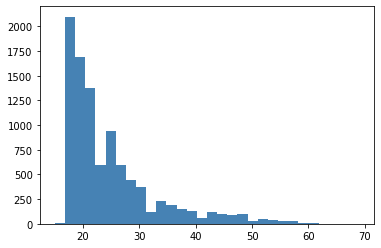

In [245]:
#look at distribution of entryage
plt.hist(merged_2C['EntryAge'], bins=30, color='steelblue')


In [246]:
medianAge=merged_2C.EntryAge.median()
medianAge

22.0

Since the distribution of `EntryAge` is skewed to the right, I will impute the missing value with the median age 22.

In [247]:
merged_2C['EntryAge_Imp']=merged_2C['EntryAge']
merged_2C['EntryAge_Imp'].fillna(medianAge, inplace=True)
merged_2C['EntryAge_Imp'].isnull().any()

False

In [248]:
# look at the distribution of entry age again after imputation
merged_2C['EntryAge_Imp'].describe()

count    9594.000000
mean       24.699187
std         8.222169
min        15.000000
25%        19.000000
50%        22.000000
75%        27.000000
max        69.000000
Name: EntryAge_Imp, dtype: float64

In [249]:
# drop the EntryAge column
merged_2C.drop(columns=['EntryAge'], inplace=True)

In [250]:
# check again
merged_2C.isnull().any()

StudentID             False
Dropout               False
Gender                False
Hispanic              False
AmericanIndian        False
Asian                 False
Black                 False
NativeHawaiian        False
White                 False
HSDip                 False
Freshman              False
RegistrationYear      False
Minority              False
HighDeg_0             False
HighDeg_2             False
HighDeg_3             False
Final_Cum_GPA         False
Terms                 False
Start_Term_GPA        False
Final_Term_GPA        False
GPA_Growth            False
First_Year_GPA        False
Parent_AGI_Imp        False
Marital_Status_Imp    False
Father_Ed_Imp         False
Mother_Ed_Imp         False
Housing_Imp           False
State_Imp             False
MathPlacement_Imp     False
EngPlacement_Imp      False
EntryAge_Imp          False
dtype: bool

In [251]:
merged_2C.dtypes

StudentID               int64
Dropout                 int64
Gender                  int64
Hispanic                int64
AmericanIndian          int64
Asian                   int64
Black                   int64
NativeHawaiian          int64
White                   int64
HSDip                   int64
Freshman                int64
RegistrationYear        int64
Minority                int64
HighDeg_0               uint8
HighDeg_2               uint8
HighDeg_3               uint8
Final_Cum_GPA         float64
Terms                   int64
Start_Term_GPA        float64
Final_Term_GPA        float64
GPA_Growth            float64
First_Year_GPA        float64
Parent_AGI_Imp        float64
Marital_Status_Imp     object
Father_Ed_Imp          object
Mother_Ed_Imp          object
Housing_Imp            object
State_Imp              object
MathPlacement_Imp       int64
EngPlacement_Imp        int64
EntryAge_Imp          float64
dtype: object

In [252]:
#drop state_imp
merged_2C.drop(columns=['State_Imp'], inplace=True)

In [253]:
merged_2C.dtypes

StudentID               int64
Dropout                 int64
Gender                  int64
Hispanic                int64
AmericanIndian          int64
Asian                   int64
Black                   int64
NativeHawaiian          int64
White                   int64
HSDip                   int64
Freshman                int64
RegistrationYear        int64
Minority                int64
HighDeg_0               uint8
HighDeg_2               uint8
HighDeg_3               uint8
Final_Cum_GPA         float64
Terms                   int64
Start_Term_GPA        float64
Final_Term_GPA        float64
GPA_Growth            float64
First_Year_GPA        float64
Parent_AGI_Imp        float64
Marital_Status_Imp     object
Father_Ed_Imp          object
Mother_Ed_Imp          object
Housing_Imp            object
MathPlacement_Imp       int64
EngPlacement_Imp        int64
EntryAge_Imp          float64
dtype: object

In [409]:
merged_2C.shape

(9594, 30)

In [254]:
merged_2D=merged_2C.copy()

# Modeling

In [255]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics


In [256]:
merged_2D.columns

Index(['StudentID', 'Dropout', 'Gender', 'Hispanic', 'AmericanIndian', 'Asian',
       'Black', 'NativeHawaiian', 'White', 'HSDip', 'Freshman',
       'RegistrationYear', 'Minority', 'HighDeg_0', 'HighDeg_2', 'HighDeg_3',
       'Final_Cum_GPA', 'Terms', 'Start_Term_GPA', 'Final_Term_GPA',
       'GPA_Growth', 'First_Year_GPA', 'Parent_AGI_Imp', 'Marital_Status_Imp',
       'Father_Ed_Imp', 'Mother_Ed_Imp', 'Housing_Imp', 'MathPlacement_Imp',
       'EngPlacement_Imp', 'EntryAge_Imp'],
      dtype='object')

In [258]:
# define x predicative variable and y dependent variable

y=merged_2D[['Dropout']]
X=merged_2D[['Gender', 'Hispanic', 'AmericanIndian', 'Asian',
       'Black', 'NativeHawaiian', 'White', 'HSDip', 'Freshman',
       'RegistrationYear', 'Minority', 'HighDeg_0', 'HighDeg_2', 'HighDeg_3',
       'Parent_AGI_Imp', 'Marital_Status_Imp', 'Father_Ed_Imp',
       'Mother_Ed_Imp', 'Housing_Imp', 'MathPlacement_Imp',
       'EngPlacement_Imp', 'EntryAge_Imp','Final_Cum_GPA','Terms',
             'Start_Term_GPA','Final_Term_GPA','GPA_Growth','First_Year_GPA']]

# second round: dropped State_Imp, added 'Final_Cum_GPA','Terms','Start_Term_GPA','Final_Term_GPA','GPA_Growth'
# third round: added 'First_Year_GPA'; new_merged (dropped the rows with zero GPA)

### 1. Balance Labels in Training Set

We've seen from the section on the trainingset that the dataset is not balanced. There are considerably more 'non-dropouts' than 'dropouts' in our data and this might make it difficult to train a model that can effectively predict 'dropouts'. For instance, decision tree models can create biased trees if some classes dominate in the data. Therefore, we need to balance the dataset prior to fitting the models.

In [259]:
# since I've dropped some rows when imputing missing values, check the balance again
merged_2D['Dropout'].value_counts()


0    6518
1    3076
Name: Dropout, dtype: int64

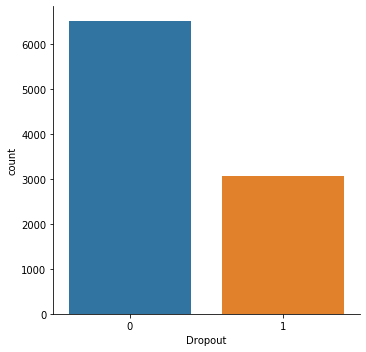

In [260]:
# visualize
sns.catplot(x='Dropout', kind='count',data=merged_2D)

Luckily, in sklearn, LogisticRegression have a parameter `class_weight` and we can set it to balanced to make sure

### 1. Logistic Regression

These categorical variables needs to be encoded: `Marital_Status_Imp`,`Father_Ed_Imp`,`Mother_Ed_Imp`, `Housing_Imp`, `State_Imp`
    
These variables needs to be normalized: `Parent_AGI`, `AGI`

In [261]:
# categorical columns
categorical= (merged_2D.dtypes=='object')
cate_cols=list(categorical[categorical].index)
print(cate_cols)

['Marital_Status_Imp', 'Father_Ed_Imp', 'Mother_Ed_Imp', 'Housing_Imp']


In [262]:
print("We start with {} features".format(len(X.columns)))

We start with 28 features


In [416]:
# Pipeline
numeric_features=['Parent_AGI_Imp']
numeric_transformer=Pipeline(steps=[('scaler', StandardScaler())])
categorical_features=cate_cols
categorical_transformer=Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
column_transformer=ColumnTransformer(transformers=[('num',numeric_transformer,numeric_features),
                                                 ('cat',categorical_transformer,categorical_features)],
                                    remainder='passthrough')
Logistic=LogisticRegression(class_weight='balanced')
feature_selection=RFECV(estimator=Logistic, cv=3, scoring='accuracy')
LogisticPipe=Pipeline([('column_transformer', column_transformer),
                       ('feature_select', feature_selection),
                       ('logisticReg',Logistic)]) 

In [417]:
# split the data

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.33, random_state=0)



In [418]:
# fit pipeline model and predict
LogisticPipe.fit(X_train,y_train)
y_pred=LogisticPipe.predict(X_test)

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/l

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [419]:
# precision, recall, f1-score, support
print(metrics.classification_report(y_pred, y_test))


              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1947
           1       0.68      0.57      0.62      1220

    accuracy                           0.73      3167
   macro avg       0.72      0.70      0.70      3167
weighted avg       0.72      0.73      0.72      3167



In [420]:
# accuracy score
from sklearn.metrics import accuracy_score
metrics.accuracy_score(y_test, y_pred)

0.7293969055888854

In [421]:
# AUC ROC Curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.7155962448733458

In [422]:
from sklearn.metrics import roc_curve
roc_curve(y_test, y_pred, pos_label=1)

(array([0.        , 0.24485019, 1.        ]),
 array([0.        , 0.67604268, 1.        ]),
 array([2, 1, 0]))

In [423]:
print("False positve rate is: {}".format(roc_curve(y_test, y_pred, pos_label=1)[0]))
print("True positve rate is: {}".format(roc_curve(y_test, y_pred, pos_label=1)[1]))
print("Threshold is: {}".format(roc_curve(y_test, y_pred, pos_label=1)[2]))

False positve rate is: [0.         0.24485019 1.        ]
True positve rate is: [0.         0.67604268 1.        ]
Threshold is: [2 1 0]


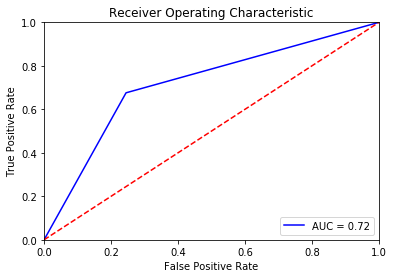

In [424]:
from sklearn.metrics import auc

# plot the AUC ROC curve
fpr, tpr, threshold=roc_curve(y_test, y_pred, pos_label=1)
roc_auc=auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [426]:
# check coefficients for logistic regression model
LogisticPipe.named_steps['logisticReg'].coef_

array([[ 0.04749075,  0.32966764,  0.10149795,  0.61356985, -0.07693405,
         0.11839107,  0.23660803,  0.80820818,  0.57631419,  0.37349621,
         0.26374935, -0.12728653,  0.65826875,  0.10659278,  0.3214117 ,
        -0.05820285,  0.3307375 , -0.43460098,  0.50490476,  0.45907773,
        -1.25242235,  0.31947119, -0.58491565,  0.46492125, -0.39230334,
         0.09009576, -0.02056375,  1.01674121, -0.96630191,  1.32189002,
         0.0314063 , -0.91579701, -0.22202042,  0.08831008, -0.26377198,
         0.06350295,  0.30631865]])

In [427]:
# check number of features selected by RFECV
LogisticPipe.named_steps['feature_select'].n_features_

37

In [467]:
LogisticPipe['column_transformer'].transformers_[1][1]

Pipeline(memory=None,
         steps=[('onehot',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop=None, dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', n_values=None,
                               sparse=True))],
         verbose=False)

In [489]:
LogisticPipe.named_steps['feature_select'].support_

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [497]:
# get the names of the 37 features selected by RFECV
numeric_features = ['Parent_AGI_Imp']
onehot_columns=np.array(LogisticPipe['column_transformer'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))
passthrough_col_index= LogisticPipe['column_transformer'].transformers_[2][2]
passthrough_cols=np.array(X_train.columns[passthrough_col_index])
transformed_col_names = np.concatenate((numeric_features, onehot_columns, passthrough_cols), axis=0)
logistic_masks=LogisticPipe.named_steps['feature_select'].support_
transformed_col_names[logistic_masks]

In [498]:
#onehot_columns=np.array(LogisticPipe['column_transformer'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))

In [499]:
#passthrough_col_index= LogisticPipe['column_transformer'].transformers_[2][2]

In [500]:
#passthrough_cols=np.array(X_train.columns[passthrough_col_index])

In [505]:
#transformed_col_names = np.concatenate((numeric_features, onehot_columns, passthrough_cols), axis=0)

In [506]:
#transformed_col_names

array(['Parent_AGI_Imp', 'Marital_Status_Imp_Divorced',
       'Marital_Status_Imp_Married', 'Marital_Status_Imp_Separated',
       'Marital_Status_Imp_Single', 'Father_Ed_Imp_College',
       'Father_Ed_Imp_High School', 'Father_Ed_Imp_Middle School',
       'Father_Ed_Imp_Unknown', 'Mother_Ed_Imp_College',
       'Mother_Ed_Imp_High School', 'Mother_Ed_Imp_Middle School',
       'Mother_Ed_Imp_Unknown', 'Housing_Imp_Off Campus',
       'Housing_Imp_On Campus Housing', 'Housing_Imp_With Parent',
       'Gender', 'Hispanic', 'AmericanIndian', 'Asian', 'Black',
       'NativeHawaiian', 'White', 'HSDip', 'Freshman', 'RegistrationYear',
       'Minority', 'HighDeg_0', 'HighDeg_2', 'HighDeg_3',
       'MathPlacement_Imp', 'EngPlacement_Imp', 'EntryAge_Imp',
       'Final_Cum_GPA', 'Terms', 'Start_Term_GPA', 'Final_Term_GPA',
       'GPA_Growth', 'First_Year_GPA'], dtype=object)

In [508]:
#logistic_masks=LogisticPipe.named_steps['feature_select'].support_

In [509]:
#transformed_col_names[logistic_masks]

array(['Parent_AGI_Imp', 'Marital_Status_Imp_Married',
       'Marital_Status_Imp_Separated', 'Marital_Status_Imp_Single',
       'Father_Ed_Imp_College', 'Father_Ed_Imp_High School',
       'Father_Ed_Imp_Middle School', 'Father_Ed_Imp_Unknown',
       'Mother_Ed_Imp_College', 'Mother_Ed_Imp_High School',
       'Mother_Ed_Imp_Middle School', 'Mother_Ed_Imp_Unknown',
       'Housing_Imp_Off Campus', 'Housing_Imp_On Campus Housing',
       'Housing_Imp_With Parent', 'Gender', 'Hispanic', 'AmericanIndian',
       'Asian', 'Black', 'NativeHawaiian', 'White', 'HSDip', 'Freshman',
       'Minority', 'HighDeg_0', 'HighDeg_2', 'HighDeg_3',
       'MathPlacement_Imp', 'EngPlacement_Imp', 'EntryAge_Imp',
       'Final_Cum_GPA', 'Terms', 'Start_Term_GPA', 'Final_Term_GPA',
       'GPA_Growth', 'First_Year_GPA'], dtype=object)

In [510]:
len(transformed_col_names[logistic_masks])

37

In [428]:
# # check RFECV to see which features are selected
# LogisticPipe.named_steps['feature_select'].ranking_

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [429]:
# # look at the predictors 
# def column_index(df, query_cols):
#     cols = df.columns.values
#     sidx = np.argsort(cols)
#     return sidx[np.searchsorted(cols, query_cols, sorter = sidx)]

# feature_index = []
# features = []
# column_index(X_train, X_train.columns.values)

# for num, i in enumerate(feature_selection.get_support(), start=0):
#     if i == True:
#         feature_index.append(str(num))

# for num, i in enumerate(X_train.columns.values, start=0):
#     if str(num) in feature_index:
#         features.append(X_train.columns.values[num])

# print("Features Selected: {}\n".format(len(feature_index)))
# print("Features Indexes: \n{}\n".format(feature_index))
# print("Feature Names: \n{}".format(features))


Features Selected: 37

Features Indexes: 
['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

Feature Names: 
['Gender', 'AmericanIndian', 'Asian', 'Black', 'NativeHawaiian', 'White', 'HSDip', 'Freshman', 'RegistrationYear', 'Minority', 'HighDeg_0', 'HighDeg_2', 'HighDeg_3', 'Parent_AGI_Imp', 'Marital_Status_Imp', 'Father_Ed_Imp', 'Mother_Ed_Imp', 'Housing_Imp', 'MathPlacement_Imp', 'EngPlacement_Imp', 'EntryAge_Imp', 'Final_Cum_GPA', 'Terms', 'Start_Term_GPA', 'GPA_Growth', 'First_Year_GPA']


### 2. SVM

In [430]:
# SVMPipe
SVM_model=SVC(kernel='rbf', class_weight='balanced')
#feature_selection_2=RFECV(estimator=SVM_model, cv=3, scoring='accuracy')
SVMPipe=Pipeline([('column_transformer', column_transformer),
                  #('feature',feature_selection_2),
                       ('svm',SVM_model)])

In [431]:
# grid search to find best parameters for c and gamma
param_grid= {'svm__C': [1,5,10,50],
           'svm__gamma': [0.001,0.005,0.001,0.005]}
grid=GridSearchCV(SVMPipe, param_grid)
grid.fit(X_train, y_train)
print(grid.best_params_)

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expec

{'svm__C': 50, 'svm__gamma': 0.005}


In [432]:
# predict
SVM_best_model=grid.best_estimator_
y_predit_svm=SVM_best_model.predict(X_test)

In [433]:
# precision, recall, f1-score, support
print(metrics.classification_report(y_predit_svm, y_test))


              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2162
           1       0.79      0.81      0.80      1005

    accuracy                           0.87      3167
   macro avg       0.85      0.85      0.85      3167
weighted avg       0.87      0.87      0.87      3167



In [434]:
# accuracy score and AUC
print("Accuracy score for SVM is: {}".format(metrics.accuracy_score(y_test, y_predit_svm)))
print("AUC is: {}".format(roc_auc_score(y_test, y_predit_svm)))

0.8699084306915061

In [435]:
# AUC ROC Curve
#roc_auc_score(y_test, y_predit_svm)

0.8486145319078601

In [436]:
roc_curve(y_test, y_predit_svm, pos_label=1)

(array([0.        , 0.09035581, 1.        ]),
 array([0.        , 0.78758487, 1.        ]),
 array([2, 1, 0]))

In [437]:
print("False positve rate is: {}".format(roc_curve(y_test, y_predit_svm, pos_label=1)[0]))
print("True positve rate is: {}".format(roc_curve(y_test, y_predit_svm, pos_label=1)[1]))
print("Threshold is: {}".format(roc_curve(y_test, y_predit_svm, pos_label=1)[2]))

False positve rate is: [0.         0.09035581 1.        ]
True positve rate is: [0.         0.78758487 1.        ]
Threshold is: [2 1 0]


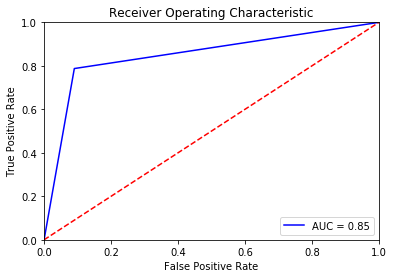

In [438]:
# plot the AUC ROC curve
fpr, tpr, threshold=roc_curve(y_test, y_predit_svm, pos_label=1)
roc_auc=auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



### 3. Random Forest

In [448]:
RFC=RandomForestClassifier(n_estimators=100, random_state=0) #added max_depth=5
Random_Forest_Select=SelectFromModel(RFC)
RandomForest_Pipe=Pipeline([('column_transformer', column_transformer), 
                            ('features',Random_Forest_Select), # add feature selection step to improve accuracy
                       ('RandomForest',RFC)])
RandomForest_Pipe.fit(X_train, y_train)
y_pred_RF=RandomForest_Pipe.predict(X_test)


#DecisionTreeClassifier(max_depth=5,class_weight='balanced')

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/from_model.py:196: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [449]:
# precision, recall, f1-score, support
print(metrics.classification_report(y_pred_RF, y_test))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2355
           1       0.70      0.89      0.78       812

    accuracy                           0.87      3167
   macro avg       0.83      0.88      0.85      3167
weighted avg       0.89      0.87      0.88      3167



In [450]:
# Accuracy and AUC
print("Accuracy of Random Forest model is: {}".format(roc_auc_score(y_test, y_pred_RF)))
print("AUC is: {}".format(metrics.accuracy_score(y_test, y_pred_RF)))

0.8283590256359957

In [451]:
# accuracy score
#metrics.accuracy_score(y_test, y_pred_RF)

0.8733817492895485

In [452]:
# roc_curve
roc_curve(y_test, y_pred_RF, pos_label=1)

(array([0.      , 0.042603, 1.      ]),
 array([0.        , 0.69932105, 1.        ]),
 array([2, 1, 0]))

In [453]:
print("False positve rate is: {}".format(roc_curve(y_test, y_pred_RF, pos_label=1)[0]))
print("True positve rate is: {}".format(roc_curve(y_test, y_pred_RF, pos_label=1)[1]))
print("Threshold is: {}".format(roc_curve(y_test, y_pred_RF, pos_label=1)[2]))

False positve rate is: [0.       0.042603 1.      ]
True positve rate is: [0.         0.69932105 1.        ]
Threshold is: [2 1 0]


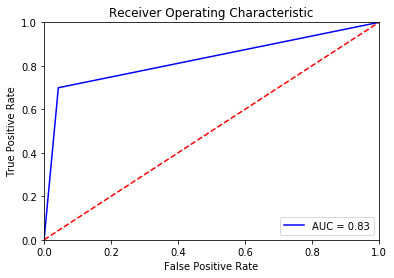

In [454]:
# plot the AUC ROC curve
fpr, tpr, threshold=roc_curve(y_test, y_pred_RF, pos_label=1)
roc_auc=auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [455]:
# feature importance for the random forest model
RandomForest_Pipe.named_steps['RandomForest'].feature_importances_

array([0.04522474, 0.17945763, 0.08004394, 0.12122205, 0.27109813,
       0.06411186, 0.08505875, 0.07478115, 0.07900175])

In [456]:
RandomForest_Pipe.named_steps['RandomForest'].n_features_

9

In [511]:
# look at the most important features selected in Random Forest
random_forest_important_feature_index=Random_Forest_Select.get_support()
random_forest_important_feature_names=transformed_col_names[random_forest_important_feature_index]
print(random_forest_important_feature_names)

In [512]:
#random_forest_important_feature_names=transformed_col_names[random_forest_important_feature_index]

In [513]:
#print(random_forest_important_feature_names)

['Parent_AGI_Imp' 'RegistrationYear' 'EntryAge_Imp' 'Final_Cum_GPA'
 'Terms' 'Start_Term_GPA' 'Final_Term_GPA' 'GPA_Growth' 'First_Year_GPA']


# Conclusion

In this case study, I have examined 39 features and their importance in three models, logistic regression, support vector machines, and Random Forest.

The 39 features are: `Gender`, `Hispanic`, `AmericanIndian`, `Asian`,
       `Black`, `NativeHawaiian`, `White`, `HSDip`, `Freshman`,
       `RegistrationYear`, `Minority`, `HighDeg_0`, `HighDeg_2`, `HighDeg_3`,
       `Parent_AGI_Imp`, `Marital_Status_Imp`, `Father_Ed_Imp`,
       `Mother_Ed_Imp`, `Housing_Imp`, `MathPlacement_Imp`,
       `EngPlacement_Imp`, `EntryAge_Imp`,`Final_Cum_GPA`,`Terms`,
             `Start_Term_GPA`,`Final_Term_GPA`,`GPA_Growth`,`First_Year_GPA`
             
Currently, the model with the highest accuracy is Random Forest, which has an accuracy score of 0.87. The best predicators from this model selected by the Random Forest feature selection method `SelectFromModel()` are `Parent_AGI_Imp` `RegistrationYear` `EntryAge_Imp` `Final_Cum_GPA`,`Terms`, `Start_Term_GPA`, `Final_Term_GPA`, `GPA_Growth`, `First_Year_GPA`. 

However, there are still a lot of rooms for improvement for the models. I will note here a few points that should be addressed to improve model accuracy:  

1. I found out in the third round of iteration that there are issues with the GPA variables that I engineered from the student progress data. Namely, there are 573 records in my dataset that have 0 `Final_Term_GPA`, 0 `Start_Term_GPA` and 0 `Final_Term_GPA`. This is because in the original dataset, there are records where the student's term GPA and final GPA are 0. This creates a problem for my variable `Final_Cum_GPA` because when I engineer this feature, I used the last cum_GPA to calculate a student's final_cum_GPA. When students in my dataset have non-zero and non-nan grades in earlier terms but zeros in the last term, the `Final_Term_GPA` will be calculated as 0 in this case, which is not correct. Because of time constraint, in my current data, I dropped all the 573 records that have 0s for `Final_Term_GPA`, 0 `Start_Term_GPA` and 0 `Final_Term_GPA`. But in doing so, I have also dropped the records where there should be a valid `Final_Cum_GPA` and `Final_Term_GPA` instead of 0. To solve this problem, I need to go back to look at if my hypothesis is correct. Related to this is the fact that there might be a data leakage issue because of the 0 GPAs I've discovered in the original dataset, I have a feeling that this might indicate the student has dropped out in that semester although the data dictionary has not indicated what a zero Term_GPA or Cum_GPA means. But if my hypthesis is true, that also might mean that I can engineer a feature similar to `Dropout` from just the zero GPA records.  

2. Another thing that I can do to improve the model performance is to scale all the numerical features since right now I have only scaled the numerical variable `Parent_AGI_Imp`. I'm also curious to see whether `AGI` actually would have an effect on dropout althought in my exploratory data analysis, I have decided to leave out this variable because the variable seems not indicate much about student attrition, but on the save side, I can add in this feature to see how the model performs.  

3. Related to this is more feature engineering tasks that I can do such as changing the `RegistrationYear` variable to categories since right now I have not changed the variable (i.e. currently it is 2011, 2012, 2013) and it obviously won't add much to the prediction as a numerical variable.  

4. There are also more refined approaches that I am considering to take about detecting and removing outliers. I tried the IQR method, which didn't work well in my data. To improve model performance, I will find better method to detect and remove outliers.   

5. Also, I've read from scholarships that some important predicators for student attrition are High School Achievement Variables such as High School GPA and SAT score, Parent education, and first year college GPA. For the dataset, currently, I have features on parent education and first year college GPA but unfortunately, I cannot use the dataset's high school unweighted GPA because about 70% of the values are missing for this variable. As such, I imagine that even if I can do the above four things, it would be difficult to improve the model beyond some threshold because one important variable that might explain a lot about the variability (classification in this case) of student attrition is missing in our data. 